<a href="https://colab.research.google.com/github/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/blob/main/draft-04-multitask-multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library


In [1]:

!pip install Sastrawi
!pip install swifter
!pip install emoji
import pandas as pd
import numpy as np
import re
import emoji
import string
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=b11b3fde388fa6a76ffa7f57bd31b2c1d8966c2937b8466ee0abaa265a1c1dbd
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.4 MB/s eta 0:00:00


In [2]:
# Loading Essential libraries
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion

# Dataset

In [3]:
# df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/draft02_dataset_review_pribadi.csv',) #draft 02
df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/3d84cf0664c4038b4ad9c4a0593c1873af83de70/draft03_dataset_review_pribadi.csv',) #draft 03
df.head()

,username,rate,date,label,sentimen,reviews,produk
0,ziaprlfauzi,4,21-05-2024 03:08 AM,fake,positive,Suka banget pake emina ini dr jaman kuliah sam...,Emina Sunscreen
1,mnisfa,4,20-05-2024 04:13 PM,fake,positive,sunscreen yang ringan banget\nengga lengket da...,Emina Sunscreen
2,amandabilla98,4,20-05-2024 07:33 AM,trusted,positive,"sunscreen jaman kuliah, cari nya gampang ada d...",Emina Sunscreen
3,mtraandita,3,19-05-2024 01:36 PM,trusted,neutral,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",Emina Sunscreen
4,Miftahuljahra,2,18-05-2024 06:38 AM,trusted,negative,Aku ga terlalu cocok pake produk ini terlebih ...,Emina Sunscreen


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2395 entries, 0 to 2394
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  2395 non-null   object
 1   rate      2395 non-null   int64 
 2   date      2395 non-null   object
 3   label     2395 non-null   object
 4   sentimen  2395 non-null   object
 5   reviews   2395 non-null   object
 6   produk    2395 non-null   object
dtypes: int64(1), object(6)
memory usage: 131.1+ KB


# EDA

In [5]:
df['text_length'] = df['reviews'].apply(len)
df.text_length.describe()

count    2395.000000
mean      235.089770
std       173.199972
min         1.000000
25%       103.000000
50%       231.000000
75%       306.000000
max      3063.000000
Name: text_length, dtype: float64

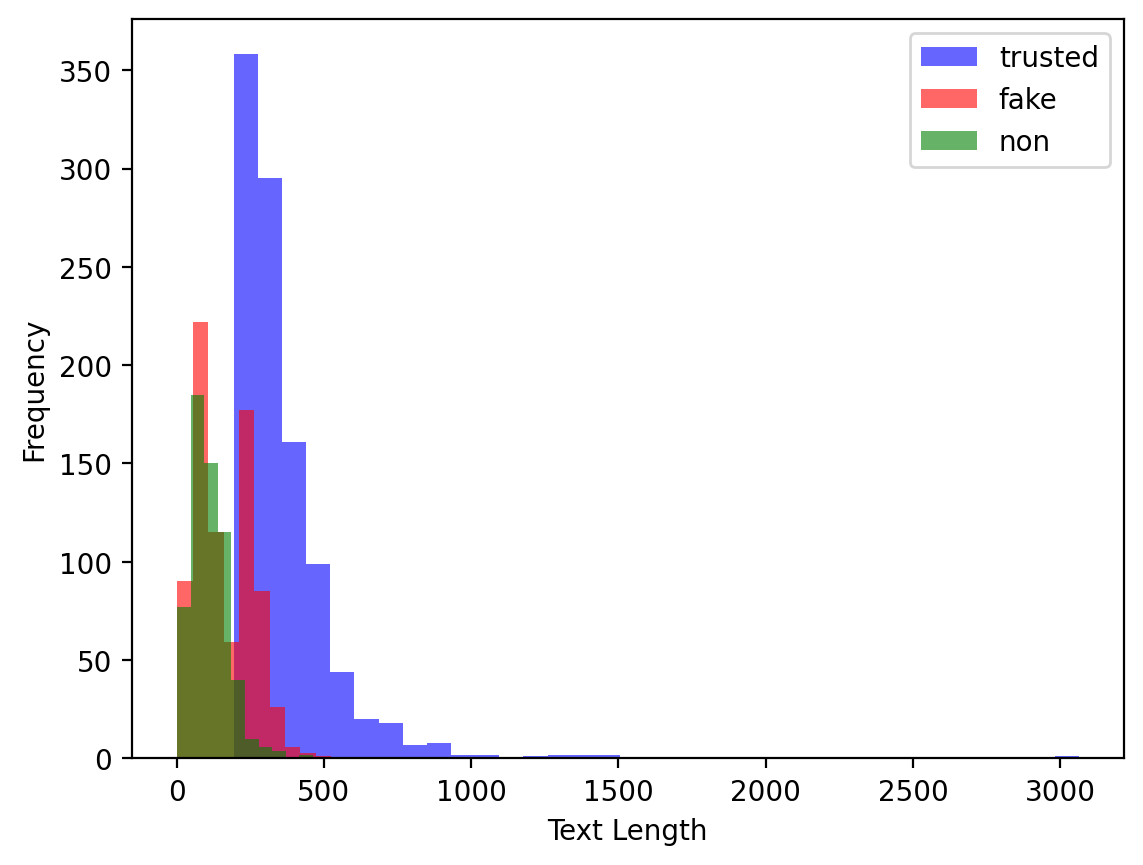

In [6]:
df[df.label=='trusted'].text_length.plot(bins=35, kind='hist', color='blue',
                                       label='trusted', alpha=0.6)
df[df.label == 'fake'].text_length.plot(kind='hist', color='red',
                                       label='fake', alpha=0.6)
df[df.label == 'non'].text_length.plot(kind='hist', color='green',
                                       label='non', alpha=0.6)
plt.legend()
plt.xlabel("Text Length")
plt.show()


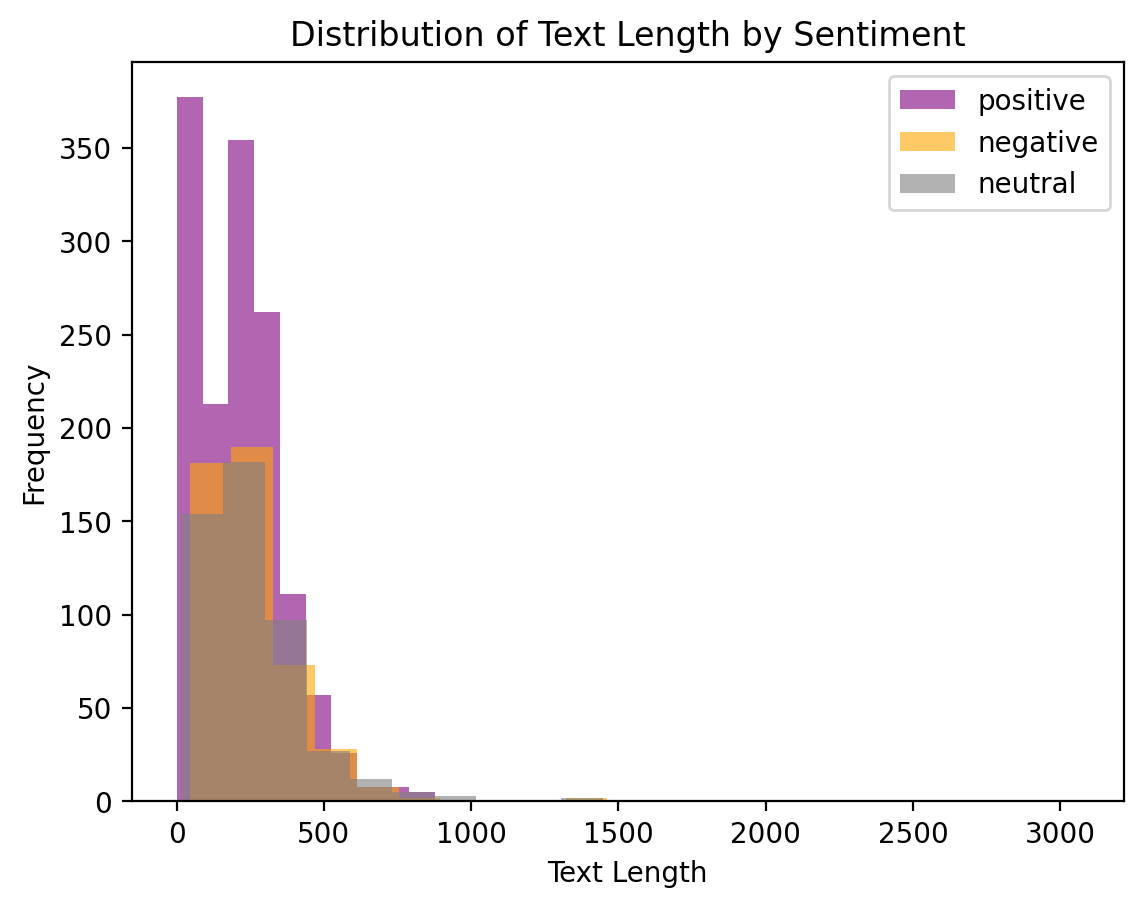

In [7]:
df[df.sentimen == 'positive'].text_length.plot(bins=35, kind='hist', color='purple',
                                               label='positive', alpha=0.6)
df[df.sentimen == 'negative'].text_length.plot(kind='hist', color='orange',
                                               label='negative', alpha=0.6)
df[df.sentimen == 'neutral'].text_length.plot(kind='hist', color='grey',
                                              label='neutral', alpha=0.6)

plt.legend()
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Length by Sentiment")
plt.show()

In [8]:
df.groupby(['label']).count()

,username,rate,date,sentimen,reviews,produk,text_length
label,,,,,,,
fake,784,784,784,784,784,784,784
non,589,589,589,589,589,589,589
trusted,1022,1022,1022,1022,1022,1022,1022


<Axes: xlabel='label', ylabel='count'>

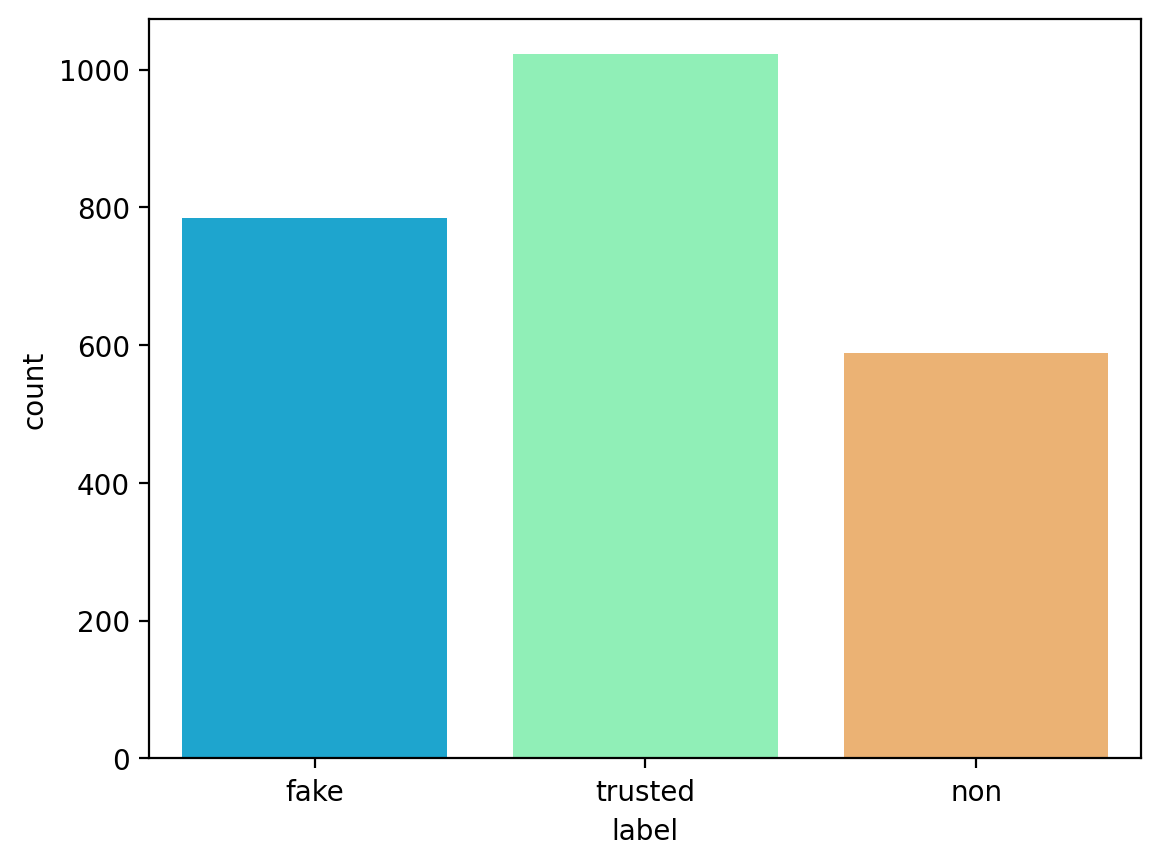

In [9]:
sns.countplot(x='label', data=df, palette='rainbow')

<Axes: xlabel='sentimen', ylabel='count'>

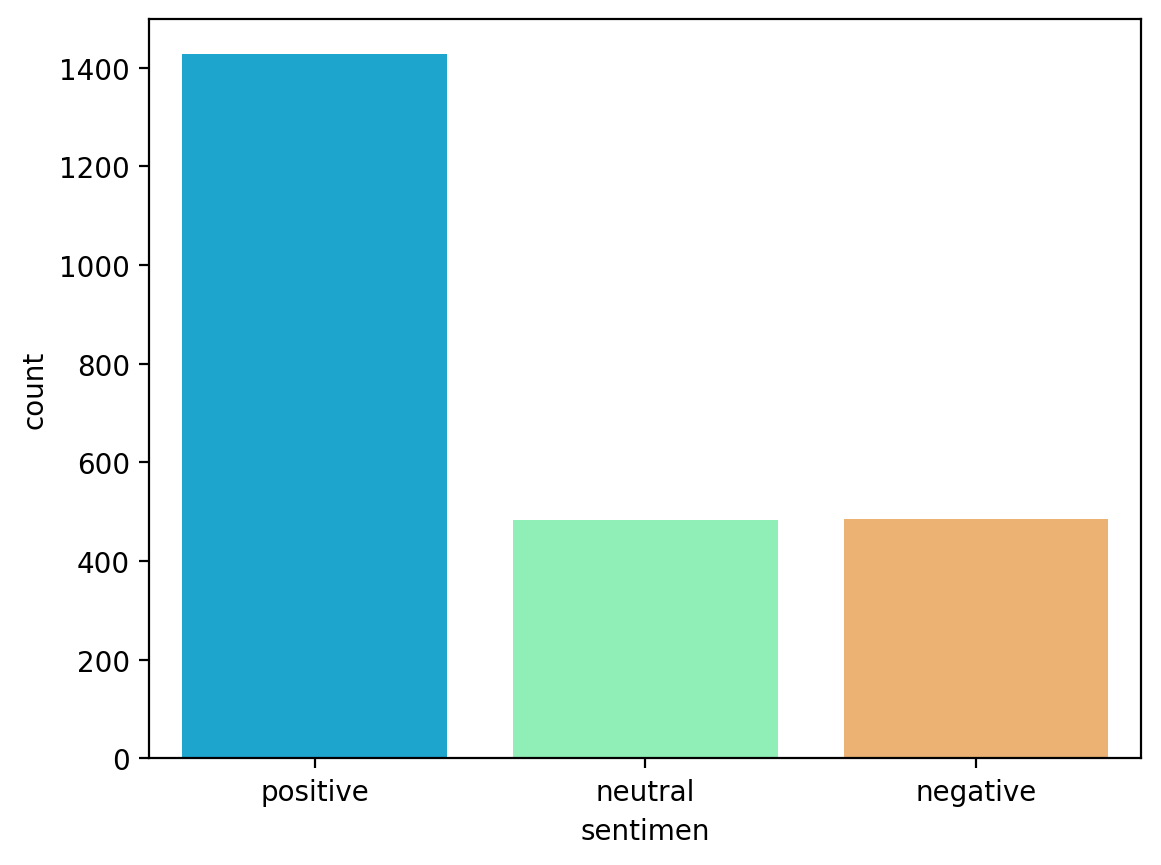

In [10]:
sns.countplot(x='sentimen', data=df, palette='rainbow')

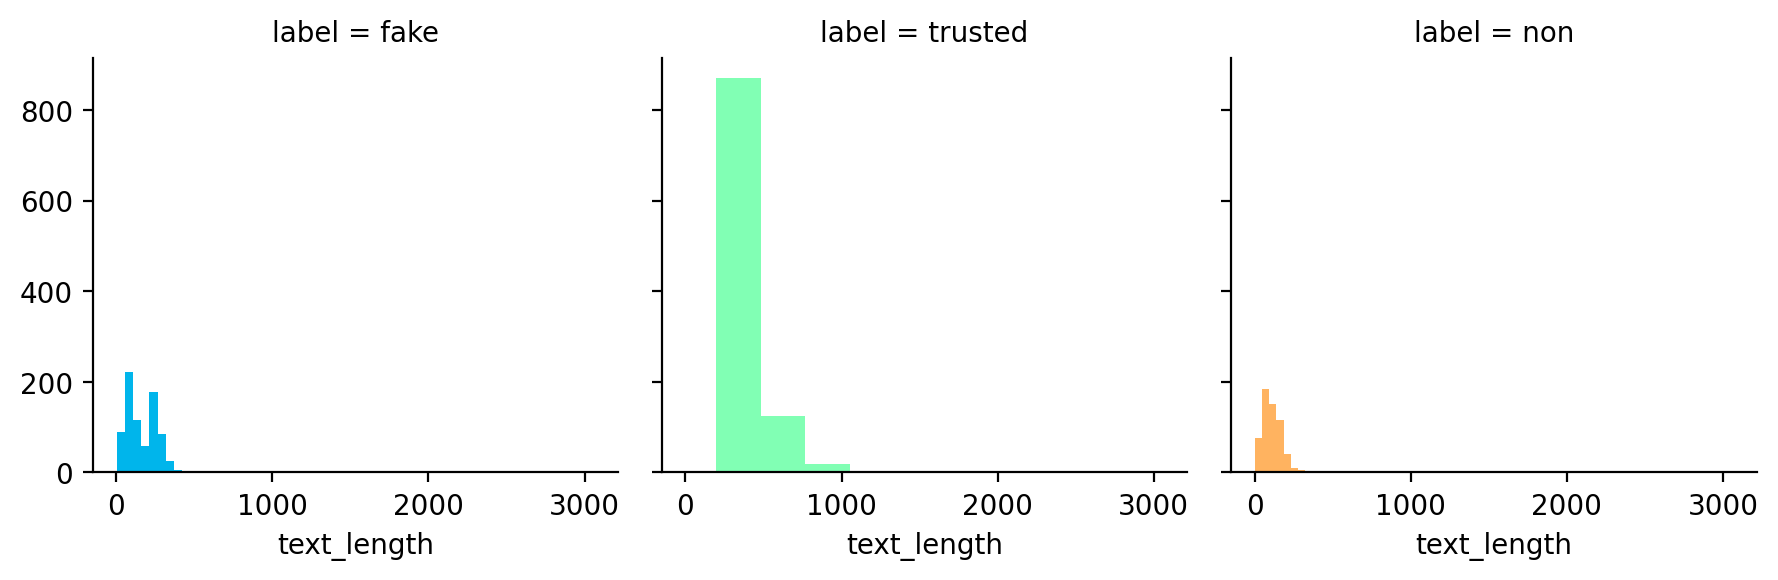

In [11]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')
plt.show()

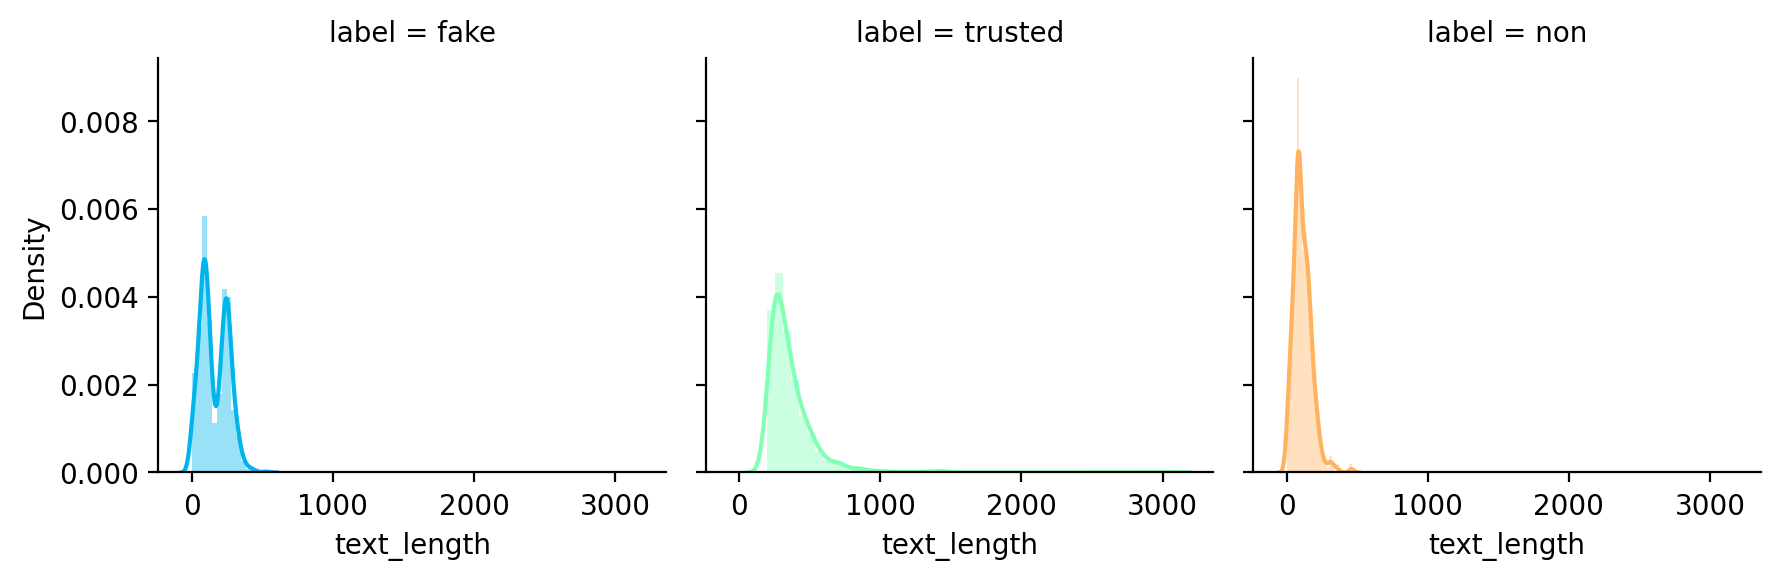

In [12]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='label', ylabel='text_length'>

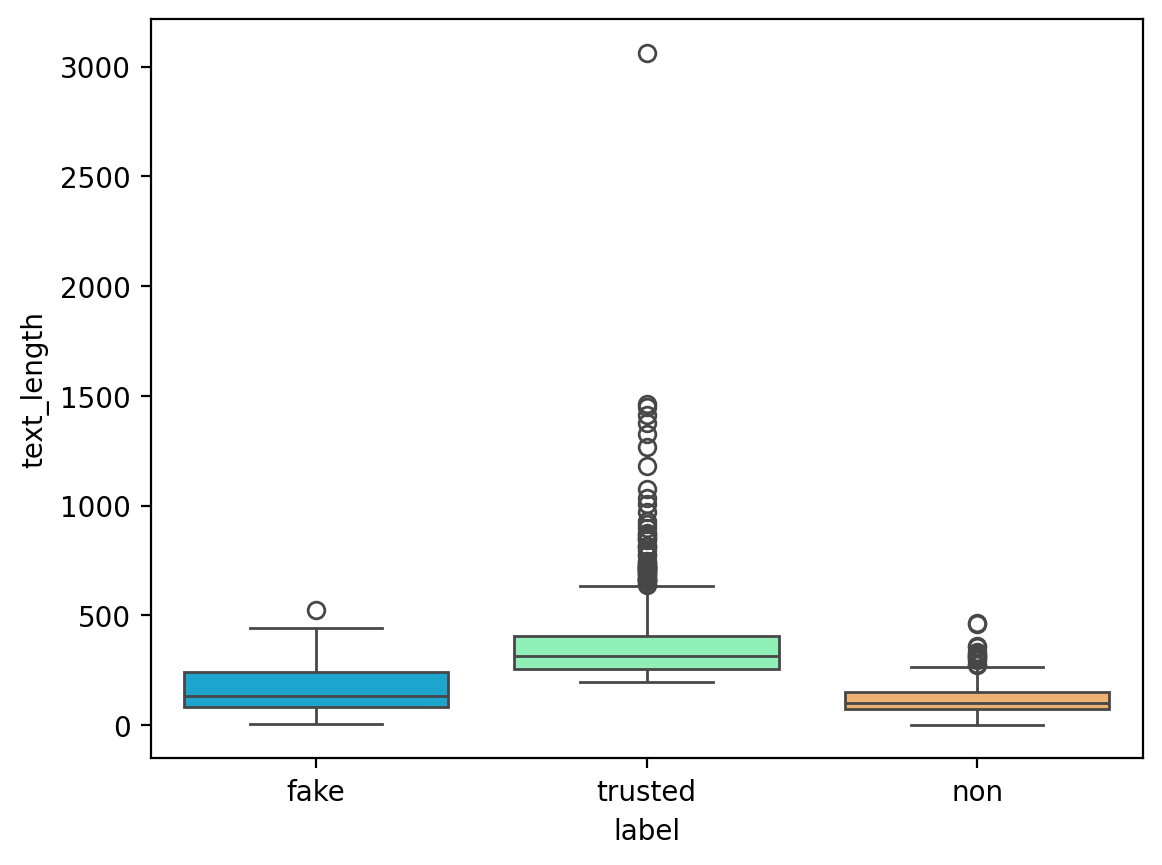

In [13]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

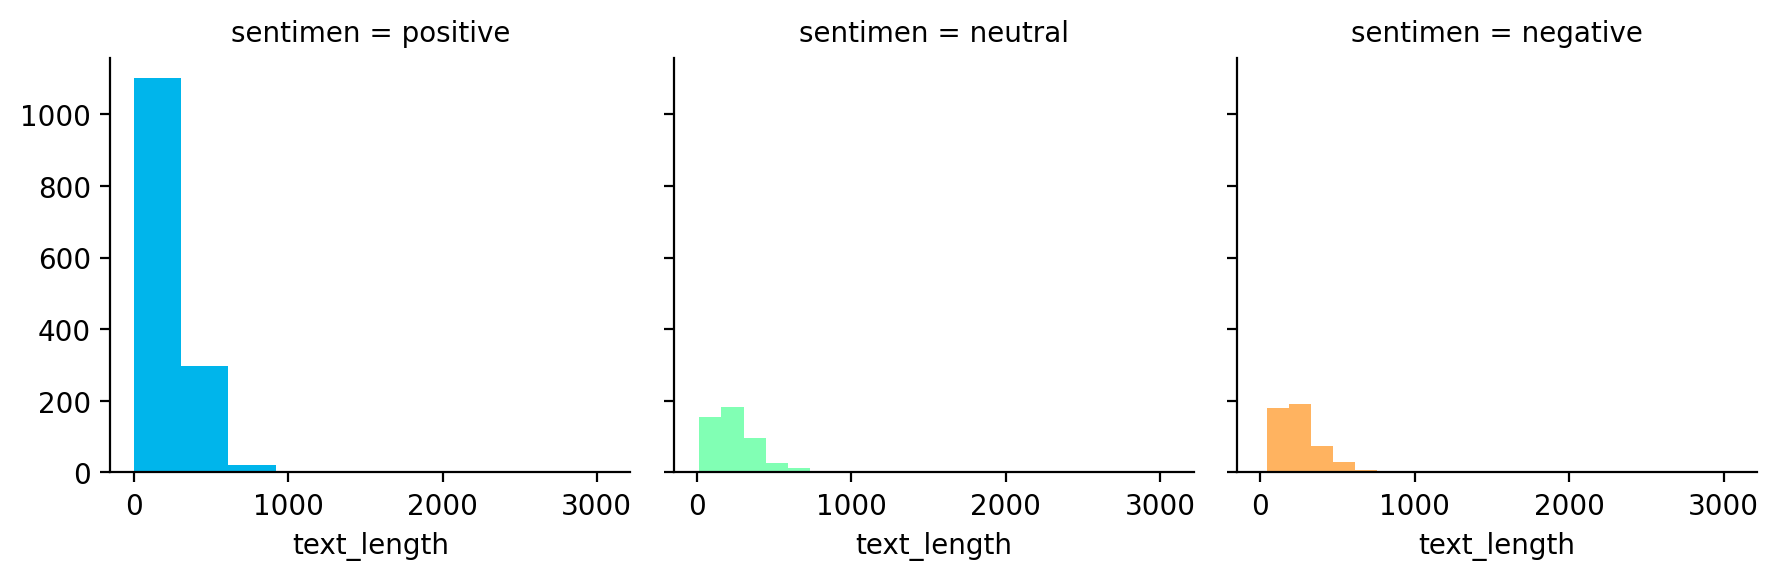

In [14]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

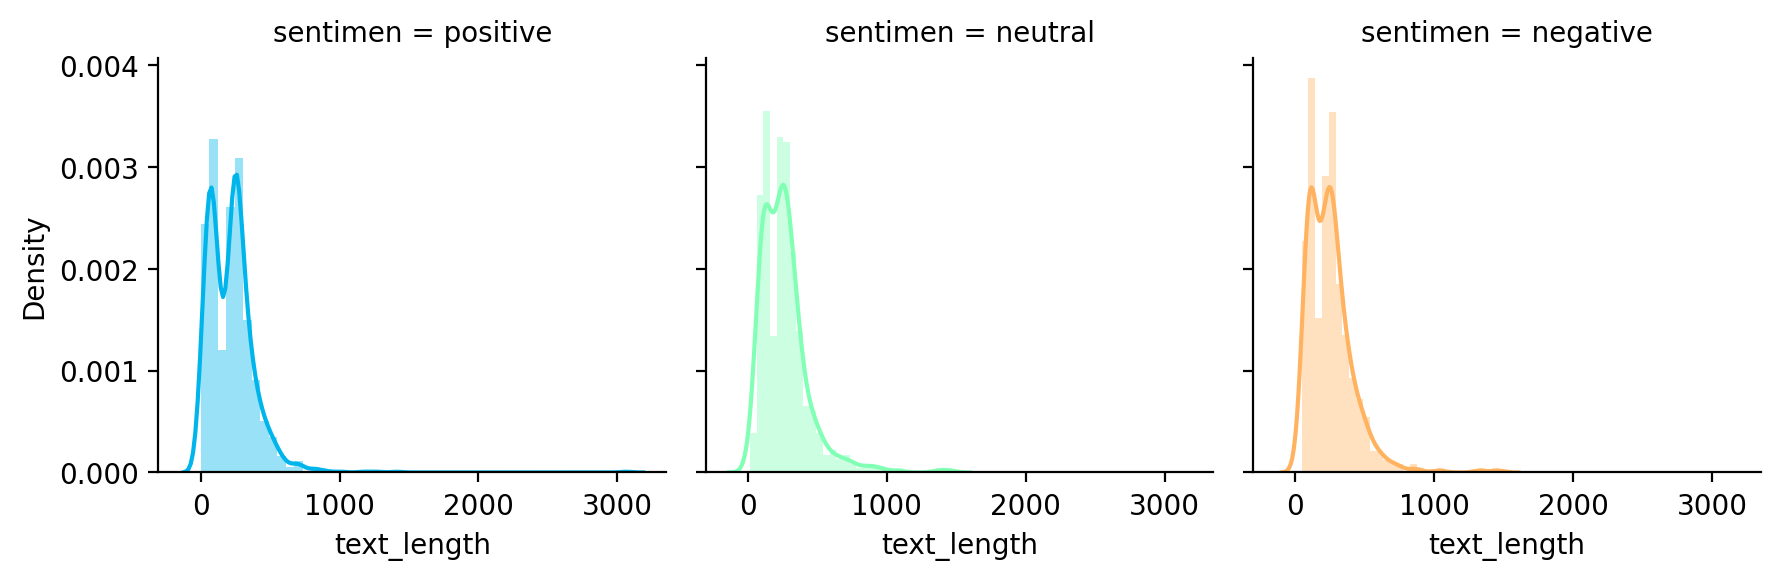

In [15]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='sentimen', ylabel='text_length'>

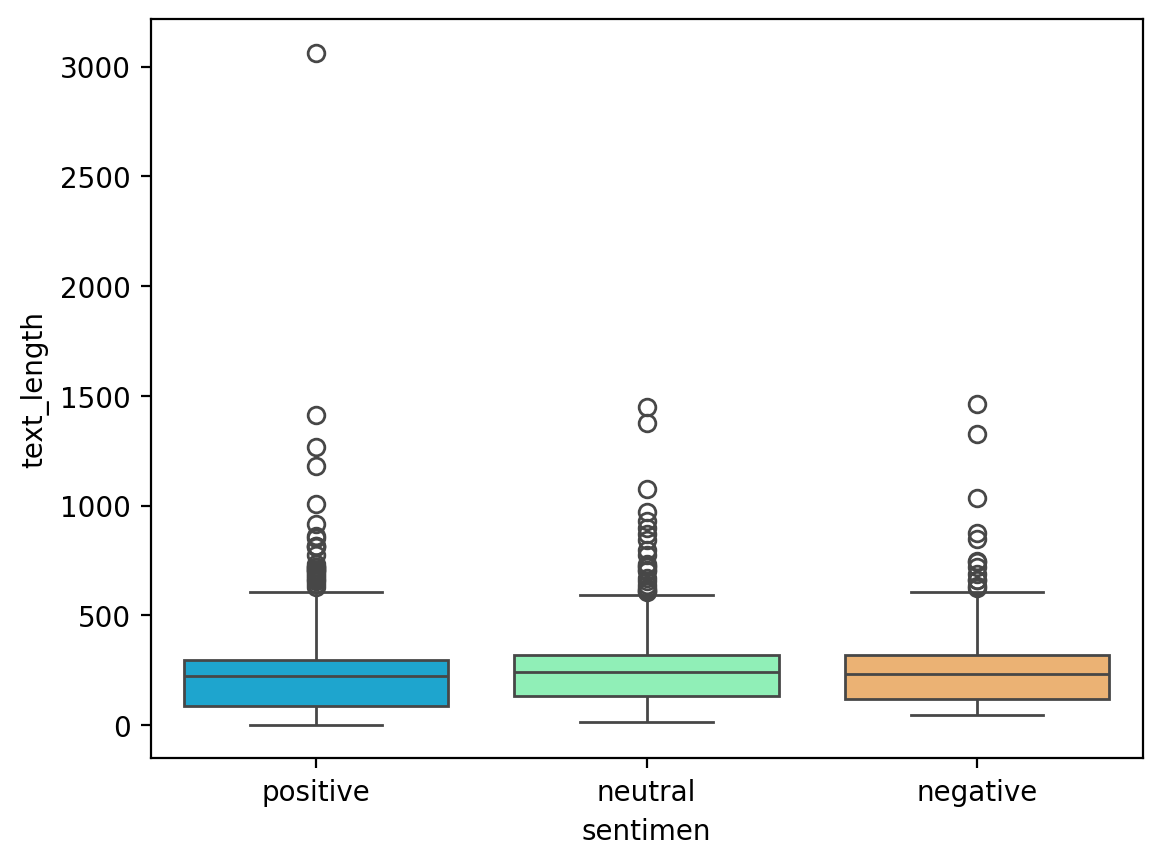

In [16]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

In [17]:
df['label'].value_counts()

label
trusted    1022
fake        784
non         589
Name: count, dtype: int64

## Missing Value & Duplicate handling

In [18]:
df.dropna(subset = ["label"], axis=0, inplace=True)

In [19]:
df = df.drop_duplicates()

In [20]:
df['label'].value_counts()

label
trusted    1022
fake        784
non         589
Name: count, dtype: int64

## Outliers Handling



In [21]:
df['text_length'] = df['reviews'].apply(len)

In [22]:
# #IQR
# Q1 = df['text_length'].quantile(0.25)
# Q3 = df['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

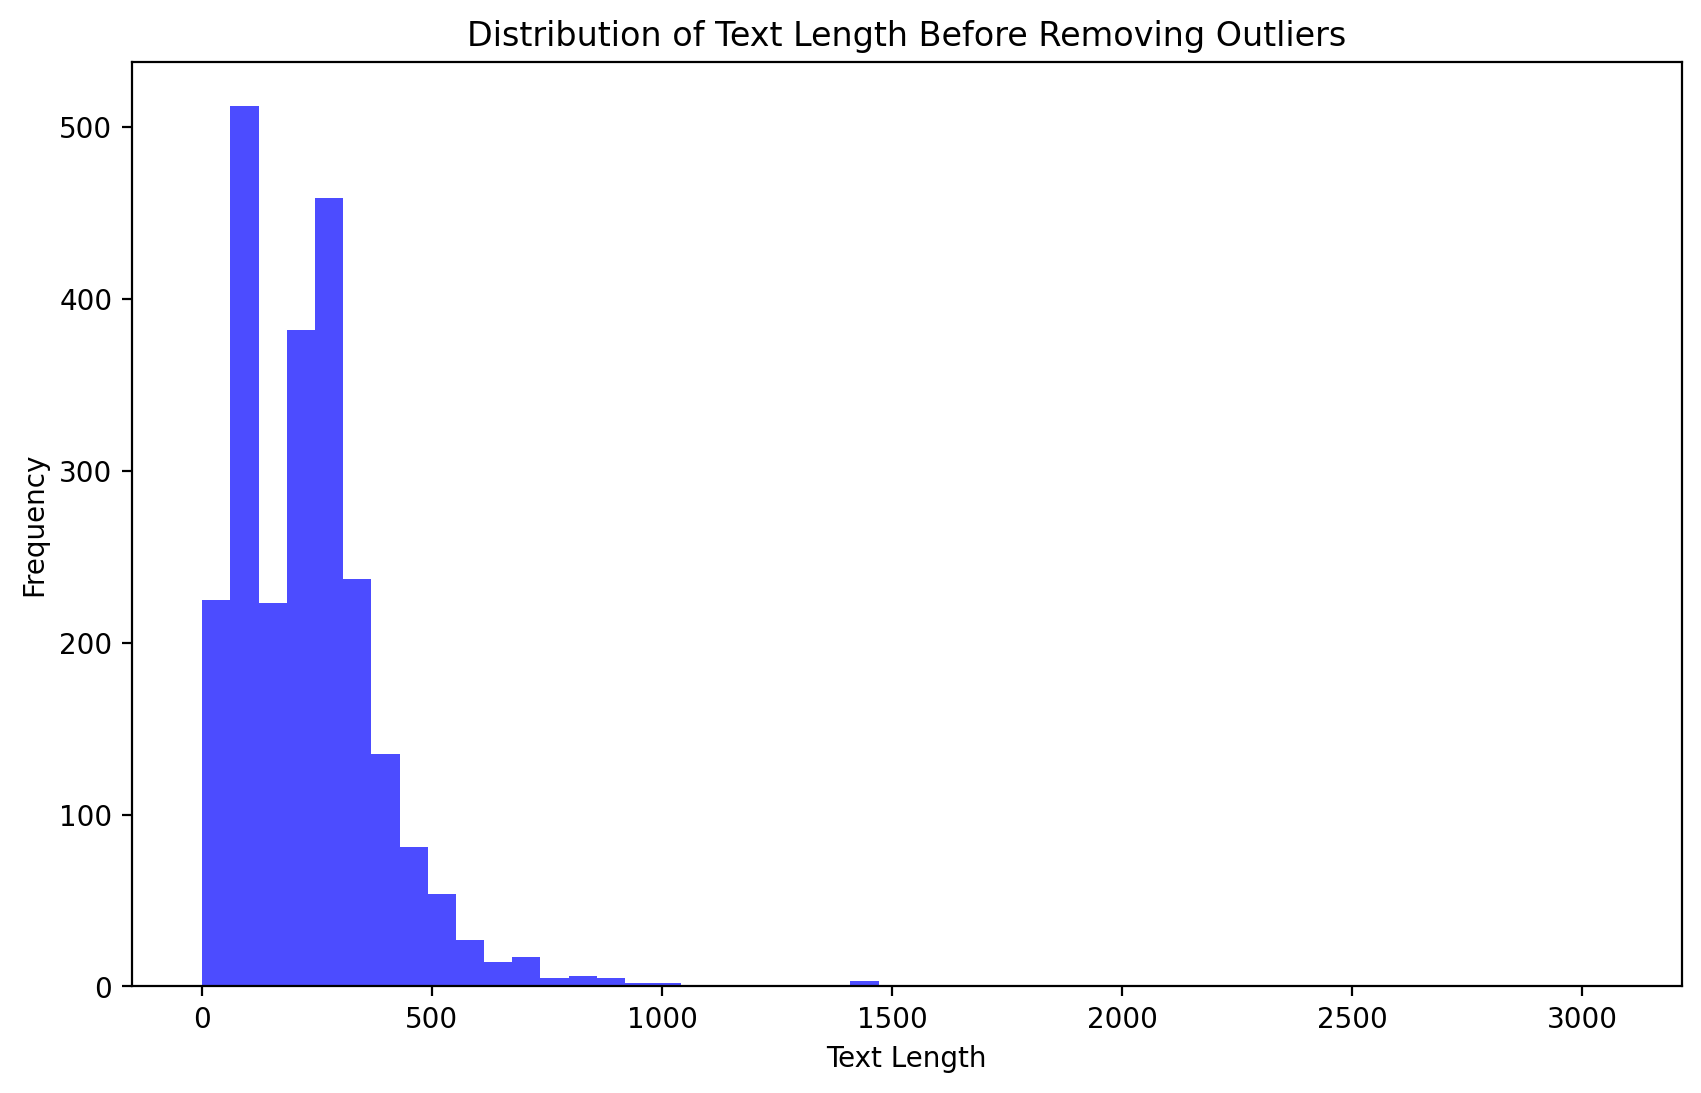

In [23]:
# Plot sebelum menghapus outlier
plt.figure(figsize=(10, 6))
df['text_length'].plot(kind='hist', bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Length Before Removing Outliers')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [24]:
#Isolation Forest

from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(df[['text_length']])
df = df[df['anomaly_score'] == 1]



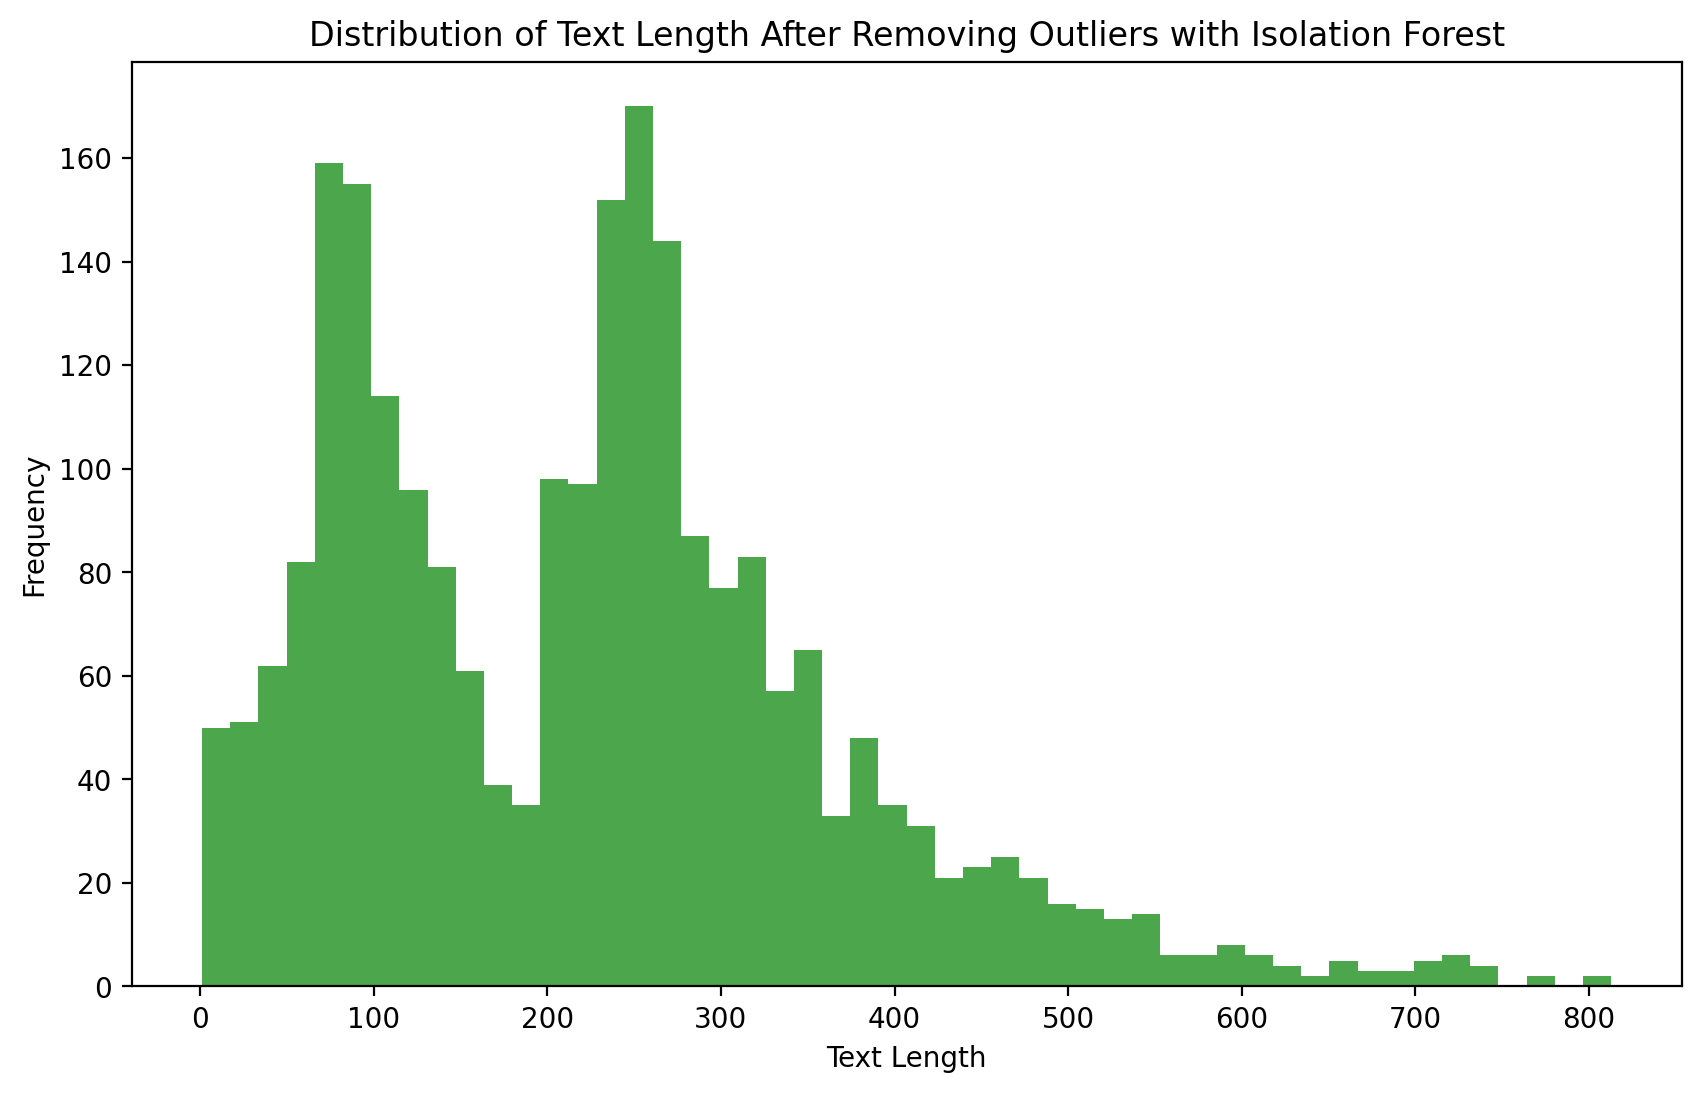

In [25]:
plt.figure(figsize=(10, 6))
df['text_length'].plot(kind='hist', bins=50, color='green', alpha=0.7)
plt.title('Distribution of Text Length After Removing Outliers with Isolation Forest')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [26]:
df.label.value_counts()

label
trusted    999
fake       784
non        589
Name: count, dtype: int64

In [27]:
df.sentimen.value_counts()

sentimen
positive    1417
negative     480
neutral      475
Name: count, dtype: int64

### Review

<Axes: xlabel='label', ylabel='text_length'>

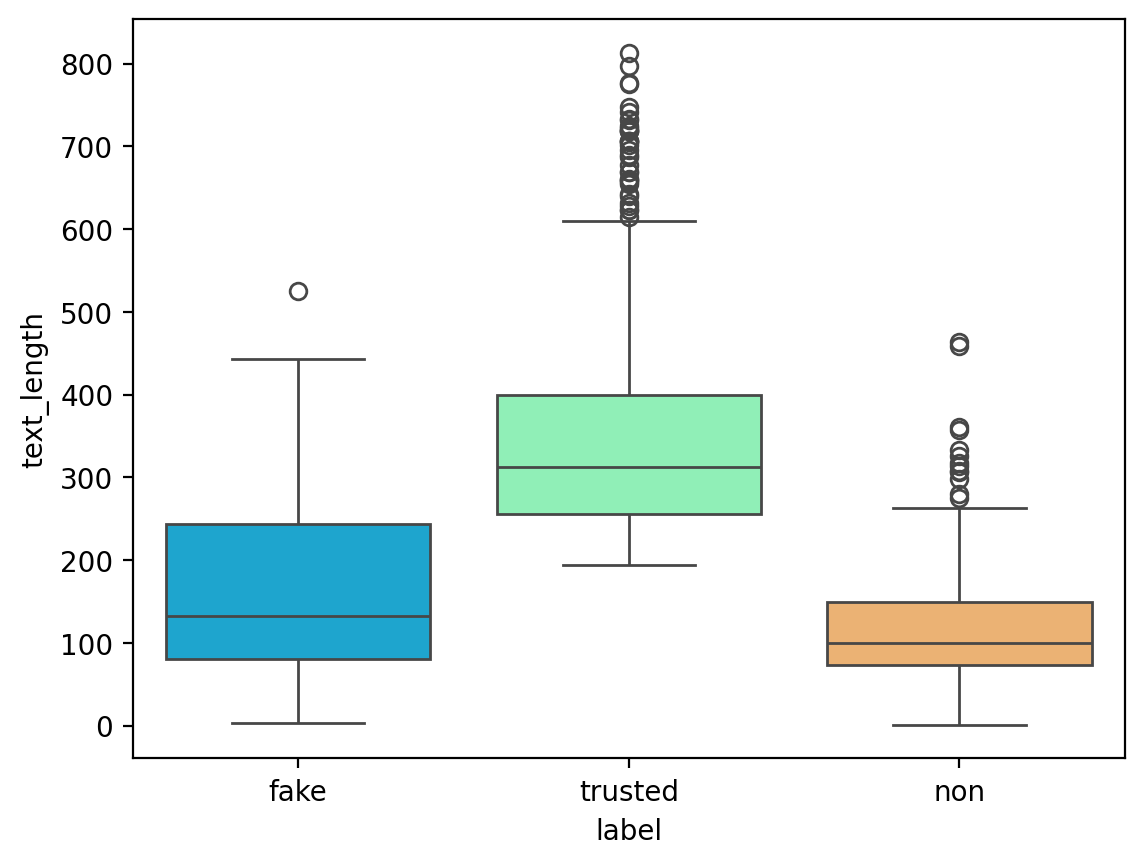

In [28]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

In [29]:
# Q1 = df[df['label'] == 'fake']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'fake']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [30]:
# Q1 = df[df['label'] == 'trusted']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'trusted']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [31]:
# Q1 = df[df['label'] == 'non']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'non']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

### Sentimen

<Axes: xlabel='sentimen', ylabel='text_length'>

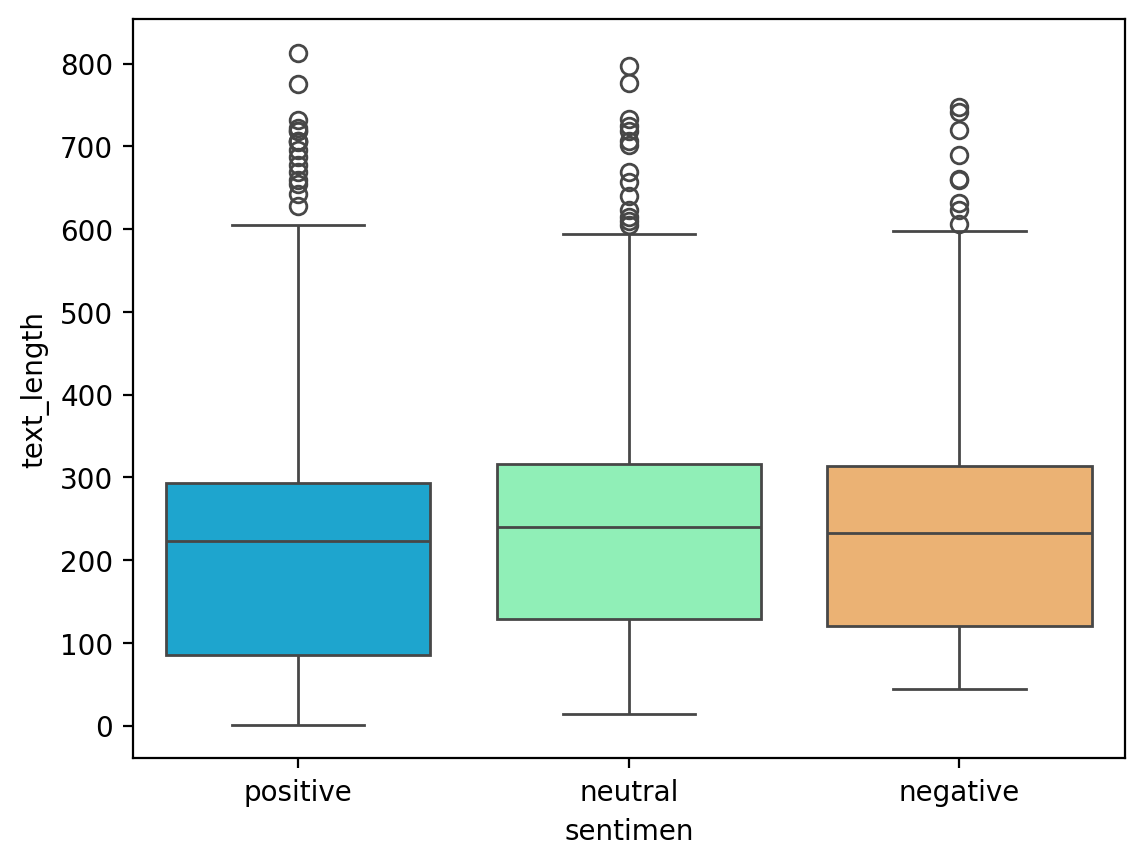

In [32]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

In [33]:
# Q1 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [34]:
# Q1 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [35]:
# Q1 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

## Show Final Distrubution & Outlier

### Review

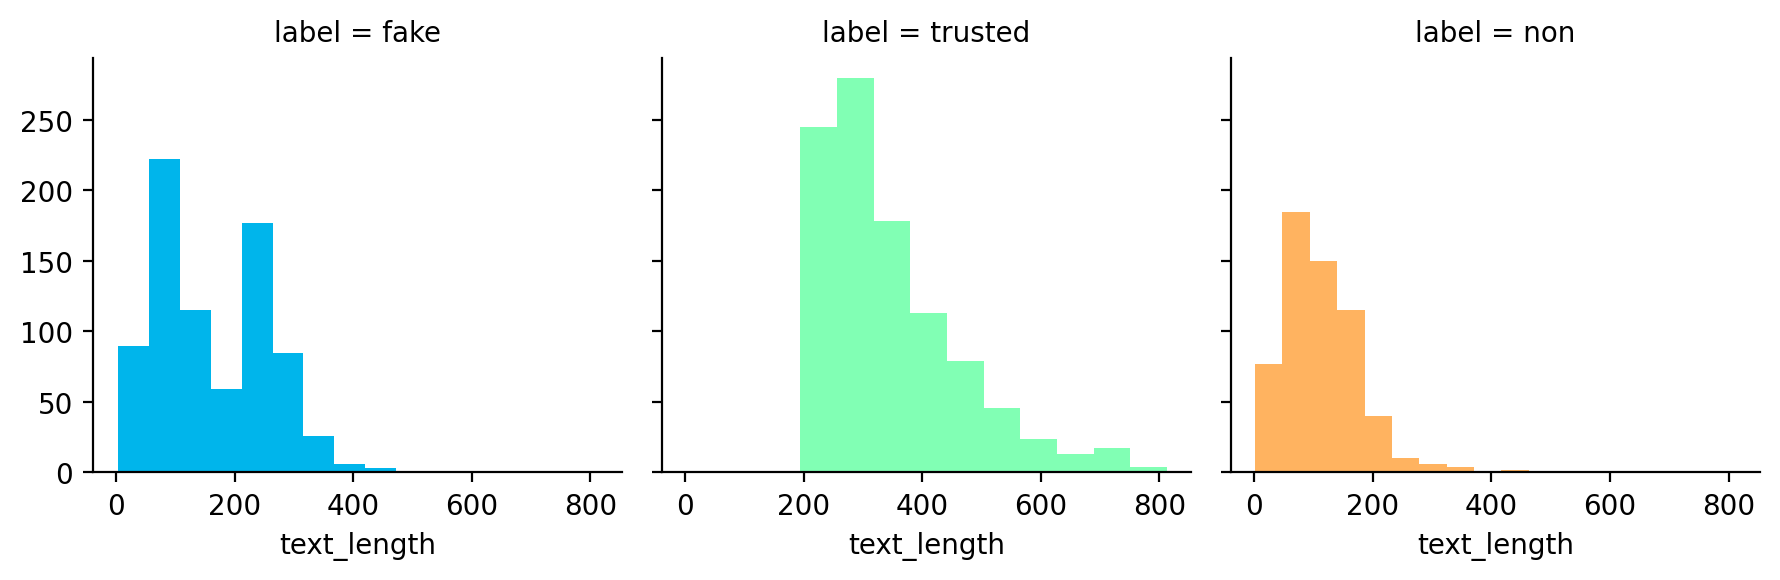

In [36]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')

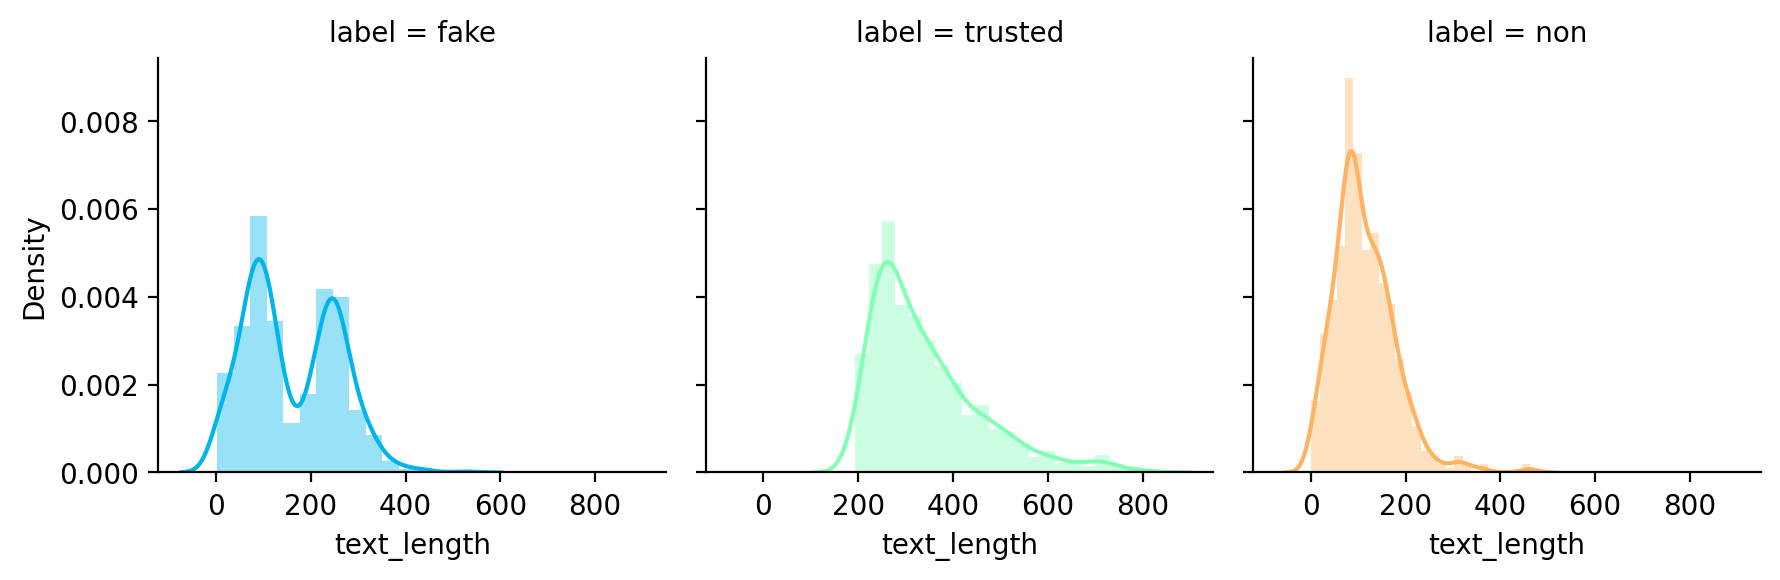

In [37]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='label', ylabel='text_length'>

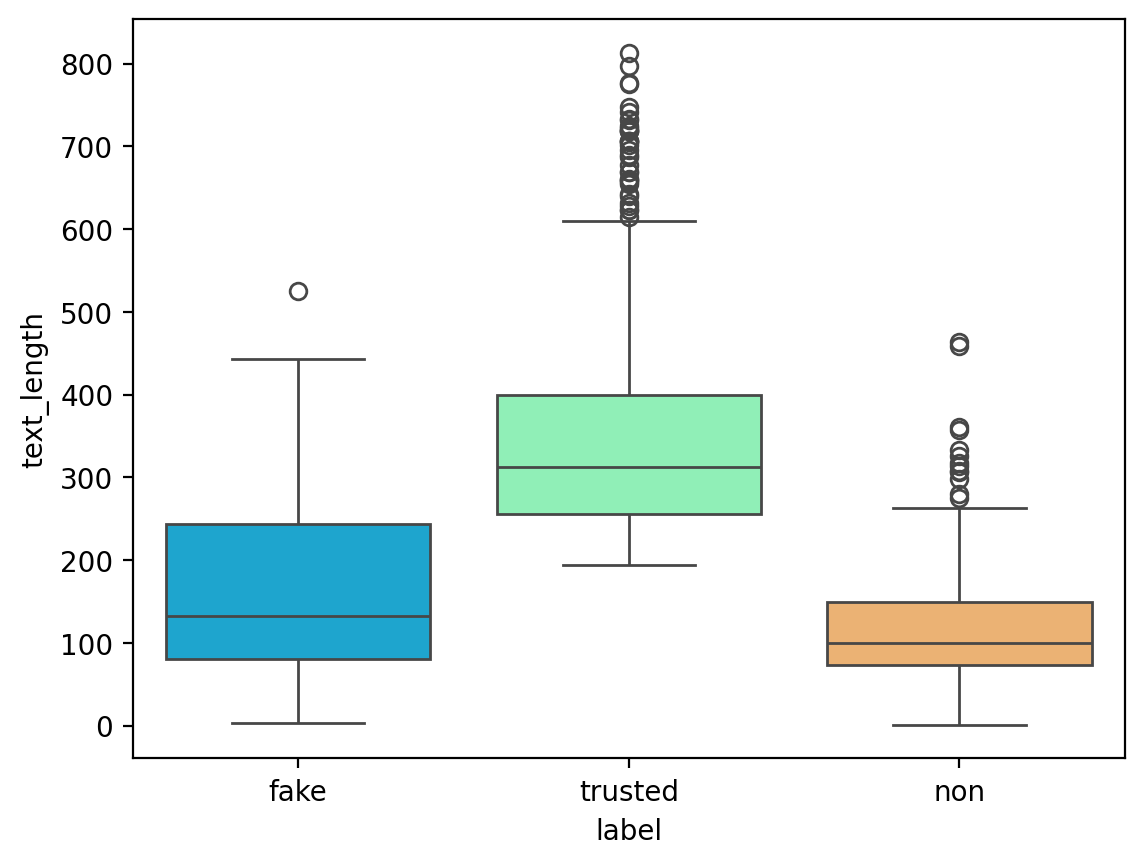

In [38]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

### Sentimen

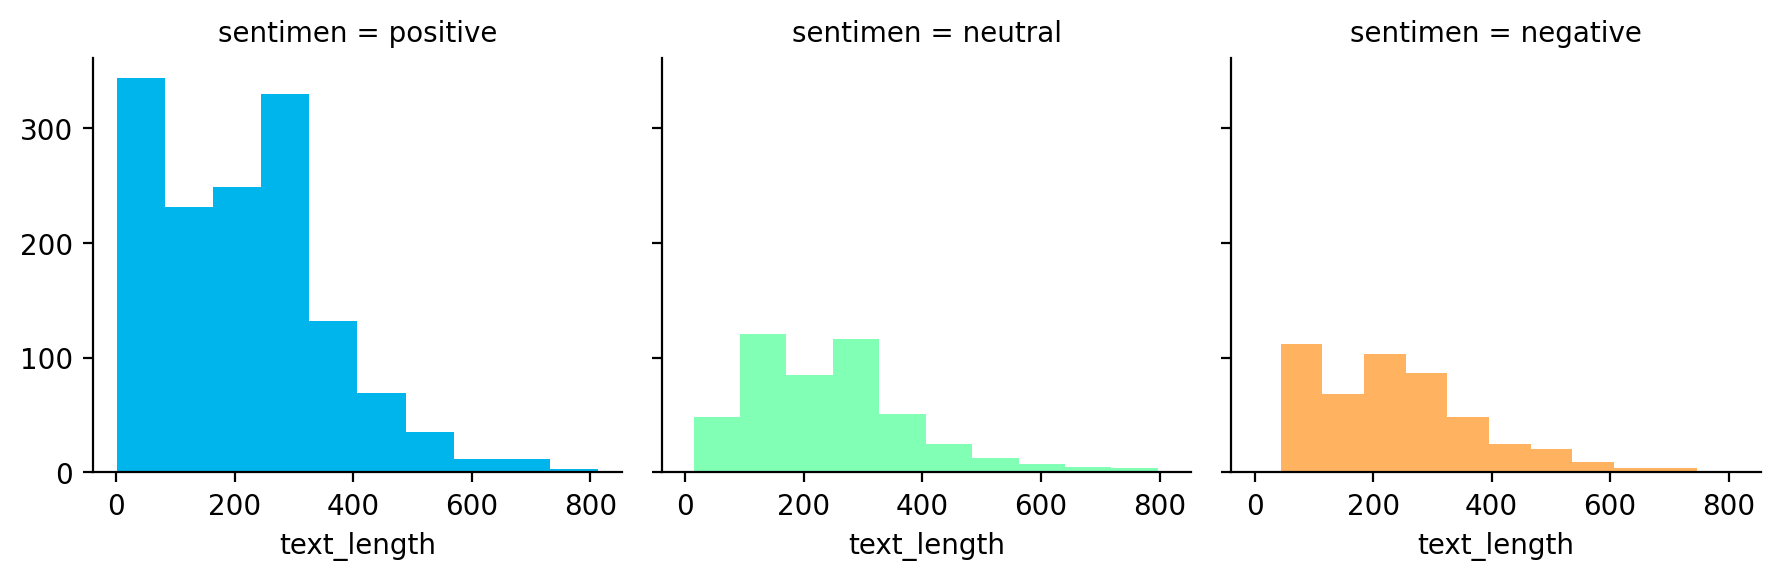

In [39]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

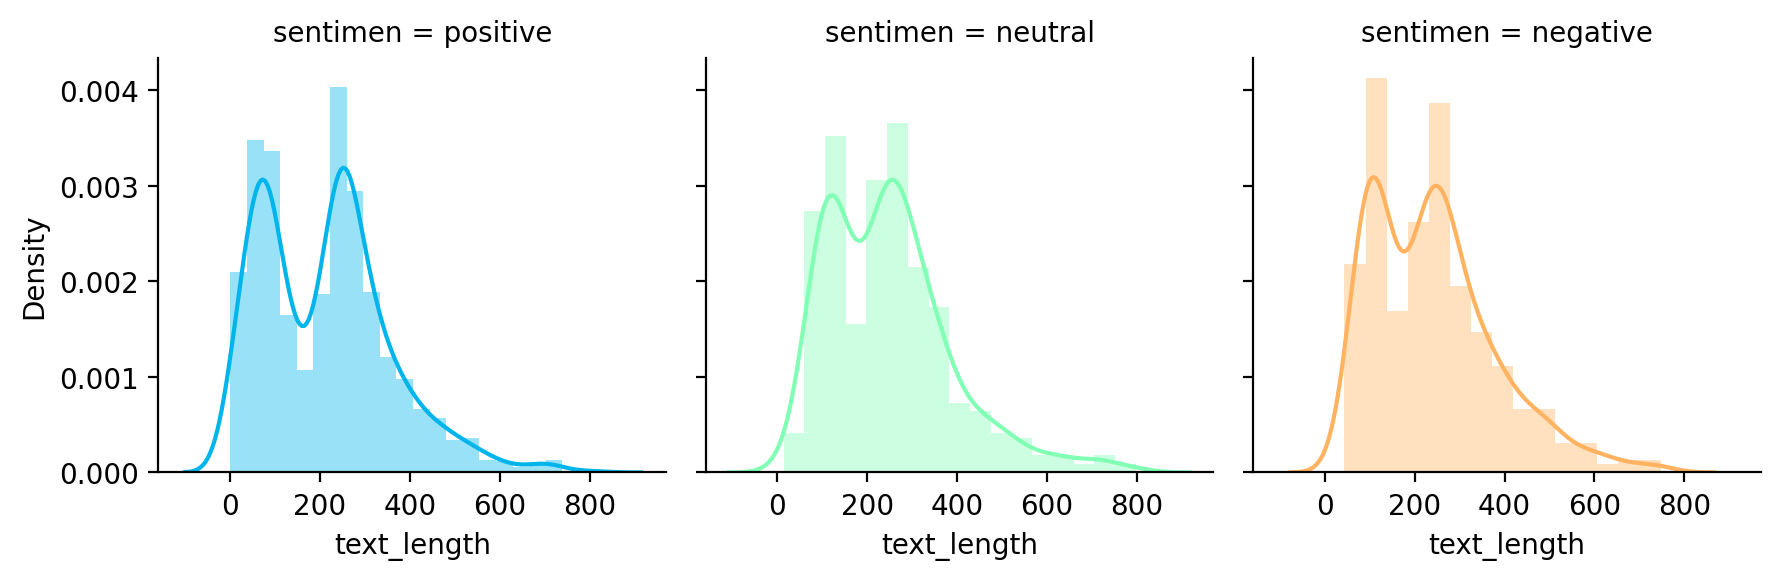

In [40]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='sentimen', ylabel='text_length'>

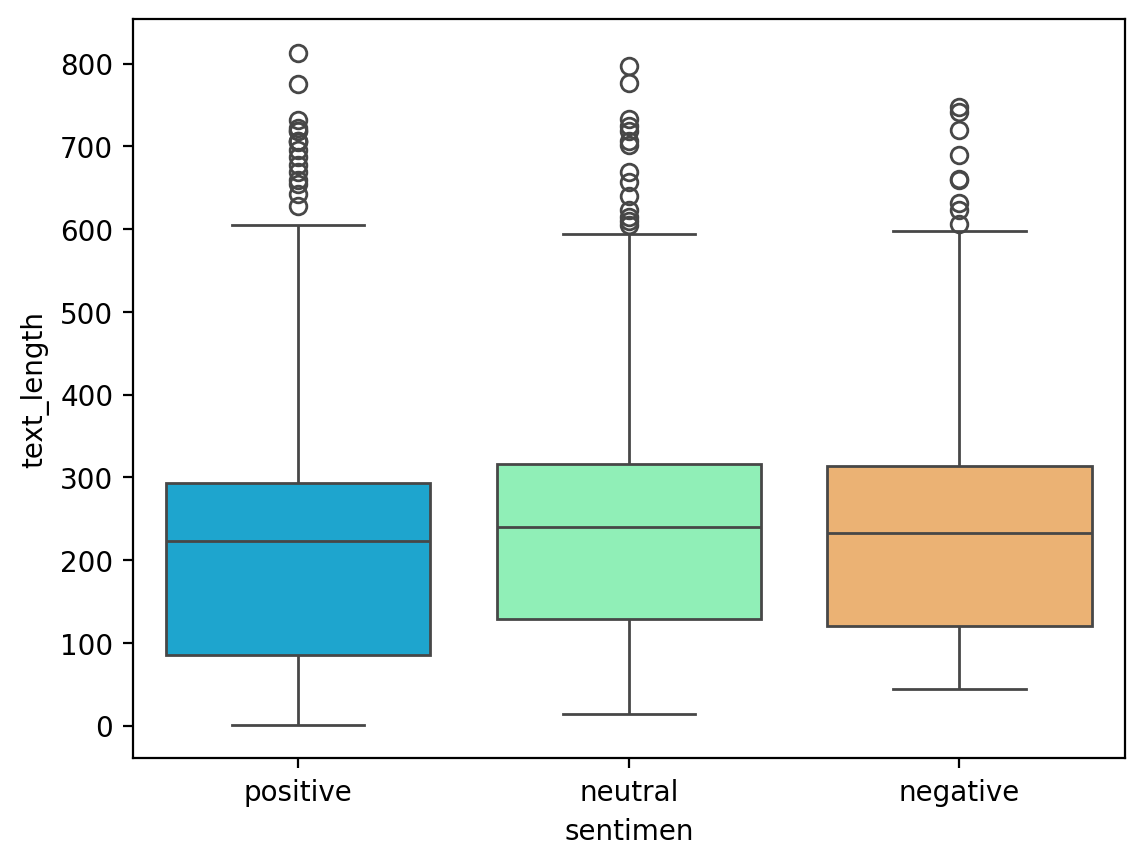

In [41]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

## Imbalance Class Handling

In [105]:
df.label.value_counts()

label
trusted    781
non        696
fake       623
Name: count, dtype: int64

In [106]:
# Resample data
label_trusted = resample(df[df['label'] == 'trusted'],
                                 replace=True,
                                 n_samples=400,
                                 random_state=123)

label_fake = resample(df[df['label'] == 'fake'],
                                 replace=True,
                                 n_samples=400,
                                 random_state=123)

label_non = resample(df[df['label'] == 'non'],
                                 replace=True,
                                 n_samples=400,
                                 random_state=123)

# Gabung ulang
df = pd.concat([label_trusted, label_fake, label_non])

df.label.value_counts()

label
trusted    400
fake       400
non        400
Name: count, dtype: int64

In [107]:
df.sentimen.value_counts()

sentimen
positive    434
negative    391
neutral     375
Name: count, dtype: int64

In [108]:
# Resample data
sentimen_neutral = resample(df[df['sentimen'] == 'neutral'],
                                 replace=True,
                                 n_samples=400,
                                 random_state=123)

sentimen_positive = resample(df[df['sentimen'] == 'positive'],
                                 replace=True,
                                 n_samples=400,
                                 random_state=123)

sentimen_negative = resample(df[df['sentimen'] == 'negative'],
                                 replace=True,
                                 n_samples=400,
                                 random_state=123)

# Gabung ulang
df = pd.concat([sentimen_neutral, sentimen_positive, sentimen_negative])

df.sentimen.value_counts()

sentimen
neutral     400
positive    400
negative    400
Name: count, dtype: int64

# Features Engeneering


## Remove Link, Hastag, Mention, Emoji

In [109]:
def cleanUpTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt) #Remove mentions
    txt = re.sub(r'#[A-Za-z0-9_]+', '', txt) #Remove hashtags
    txt = re.sub(r'RT ', '', txt) #Remove retweets
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt) #Remove urls
    return txt

In [110]:
def stripEmoji(txt):
  txt = re.sub(emoji.get_emoji_regexp(), r'', txt)
  return txt

## Remove HTML Char


In [111]:
def removeHTMLChar(text):
    text = ' '.join(re.sub("([&][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text

## Remove Punctuation

In [112]:
def remove_punctuation(txt):
  txt = re.sub(r'[^\w\s]', ' ', txt)
  return txt

In [113]:
df['reviews'] = df['reviews'].apply(remove_punctuation)

In [114]:
df['reviews'].iloc[99]

'tidak ada perubahan produk ini mudah dibilas dan tidak meninggalkan residu kulit terasa bersih dan segar setelah penggunaan'

In [115]:
df.head()

,username,rate,date,label,sentimen,reviews,produk,text_length,anomaly_score,reviews_tokens,reviews_tokens_WSW,reviews_normalized,reviews_tokens_stemmed,done_reviews,label_encoded,sentiment_encoded
2244,ilmamli,3,12-08-2015 10:02,non,neutral,rame banget yang bahas soal film animasi terba...,Lip Cream LA Girl,138,1,"[rame, banget, yang, bahas, soal, film, animas...","[rame, banget, bahas, film, animasi, terbaru, ...","[rame, banget, bahas, film, animasi, terbaru, ...","[rame, banget, bahas, film, animasi, baru, stu...",rame banget bahas film animasi baru studio kag...,1,1
2195,ellabcd,3,10-05-2021 11:56,non,neutral,marketplace sekarang banyak yang ngasih promo ...,Acnes Creamy Wash,103,1,"[marketplace, sekarang, banyak, yang, ngasih, ...","[marketplace, ngasih, promo, gede, gedean, lum...","[marketplace, ngasih, promo, gede, gedean, lum...","[marketplace, ngasih, promo, gede, gede, lumay...",marketplace ngasih promo gede gede lumayan ban...,1,1
541,ndinv,3,31-01-2016 8:46,trusted,neutral,temen gue ngga suka banget warna ini kebalikan...,Lip Cream LA Girl,336,1,"[temen, gue, ngga, suka, banget, warna, ini, k...","[temen, gue, ngga, suka, banget, warna, kebali...","[temen, gue, ngga, suka, banget, warna, kebali...","[temen, gue, ngga, suka, banget, warna, balik,...",temen gue ngga suka banget warna balik gue fle...,2,1
2016,SintaRahayu27,3,19-06-2018 11:39,fake,neutral,facial wash ini benar benar biasa saja untuk k...,Produk Skincare,56,1,"[facial, wash, ini, benar, benar, biasa, saja,...","[facial, wash, kulit]","[facial, wash, kulit]","[facial, wash, kulit]",facial wash kulit,0,1
616,syabrinand,3,16-09-2015 4:55,trusted,neutral,satu2nya penolong dari si la girl fleur ini ad...,Lip Cream LA Girl,718,1,"[satu2nya, penolong, dari, si, la, girl, fleur...","[satu2nya, penolong, girl, fleur, warnanya, fl...","[satu2nya, penolong, girl, fleur, warnanya, fl...","[satu2nya, tolong, girl, fleur, warna, fleur, ...",satu2nya tolong girl fleur warna fleur warna s...,2,1


## Remove Whitespace

In [116]:
def remove_whitespace_LT(text):
    return text.strip()

In [117]:
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

In [118]:
def spell(word):
    if re.search(r'([a-zA-Z])\1{2,}', word):
        rword = re.sub(r'([a-zA-Z])\1{2,}','\\1', word)
        return rword
    else:
        return word

In [119]:
df['reviews'] = df['reviews'].apply(remove_whitespace_LT)
df['reviews'] = df['reviews'].apply(remove_whitespace_multiple)
df['reviews'] = df['reviews'].apply(spell)

## To Lowercase

In [120]:
df["reviews"] = df["reviews"].apply(lambda item: str(item).lower())

## Remove Special Character

In [121]:
def remove_text_special(text):
    # hapus tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # hapus non ASCII (emot, bahasa china dll)
    text = text.encode('ascii', 'replace').decode('ascii')
    # hapus mention, link, hashtag
    # text = text.replace("rt", "") # revisi
    text = ' '.join(re.sub("([@#&][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove URL
    return text.replace("http://", " ").replace("https://", " ")

In [122]:
df['reviews'] = df.reviews.astype('str')
df['reviews'] = df['reviews'].apply(remove_text_special)

In [123]:
df['reviews'].iloc[88]

'temen gue ngga suka banget warna ini kebalikan sama gue menurut dia fleur ini terlalu peach di mukanya la girl ini terasa kering kalo dipake apalagi kalo ngga pake lip balm dulu baunya aneh tapi kalo udah dipake bakal ilang aplikatornya sendiri menurut gue kurang enak harganya termasuk murah untuk liquid lipstick dibawah 100rb'

# Tokenize

In [124]:
from nltk.tokenize import word_tokenize
def word_tokenize_wrapper(text):
    return word_tokenize(text)

def tokenize(word):
  word = word.split(" ")
  return word

In [125]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [126]:
df['reviews_tokens'] = df['reviews'].apply(word_tokenize_wrapper)

# Count Word

In [127]:
from collections import defaultdict
word_count = defaultdict(int)
for tokens in df["reviews_tokens"]:
    for token in tokens:
       word_count[token] += 1

In [128]:
word_count_df = pd.DataFrame({"key": word_count.keys(), "count": word_count.values()})
word_count_df_sort = word_count_df.sort_values('count', axis=0, ascending=False, inplace=False)
word_count_df_sort.head(10)

,key,count
34,ini,1052
16,dan,970
98,aku,938
2,yang,682
41,di,669
1,banget,622
50,pake,440
56,tapi,431
110,bikin,431
151,ga,412


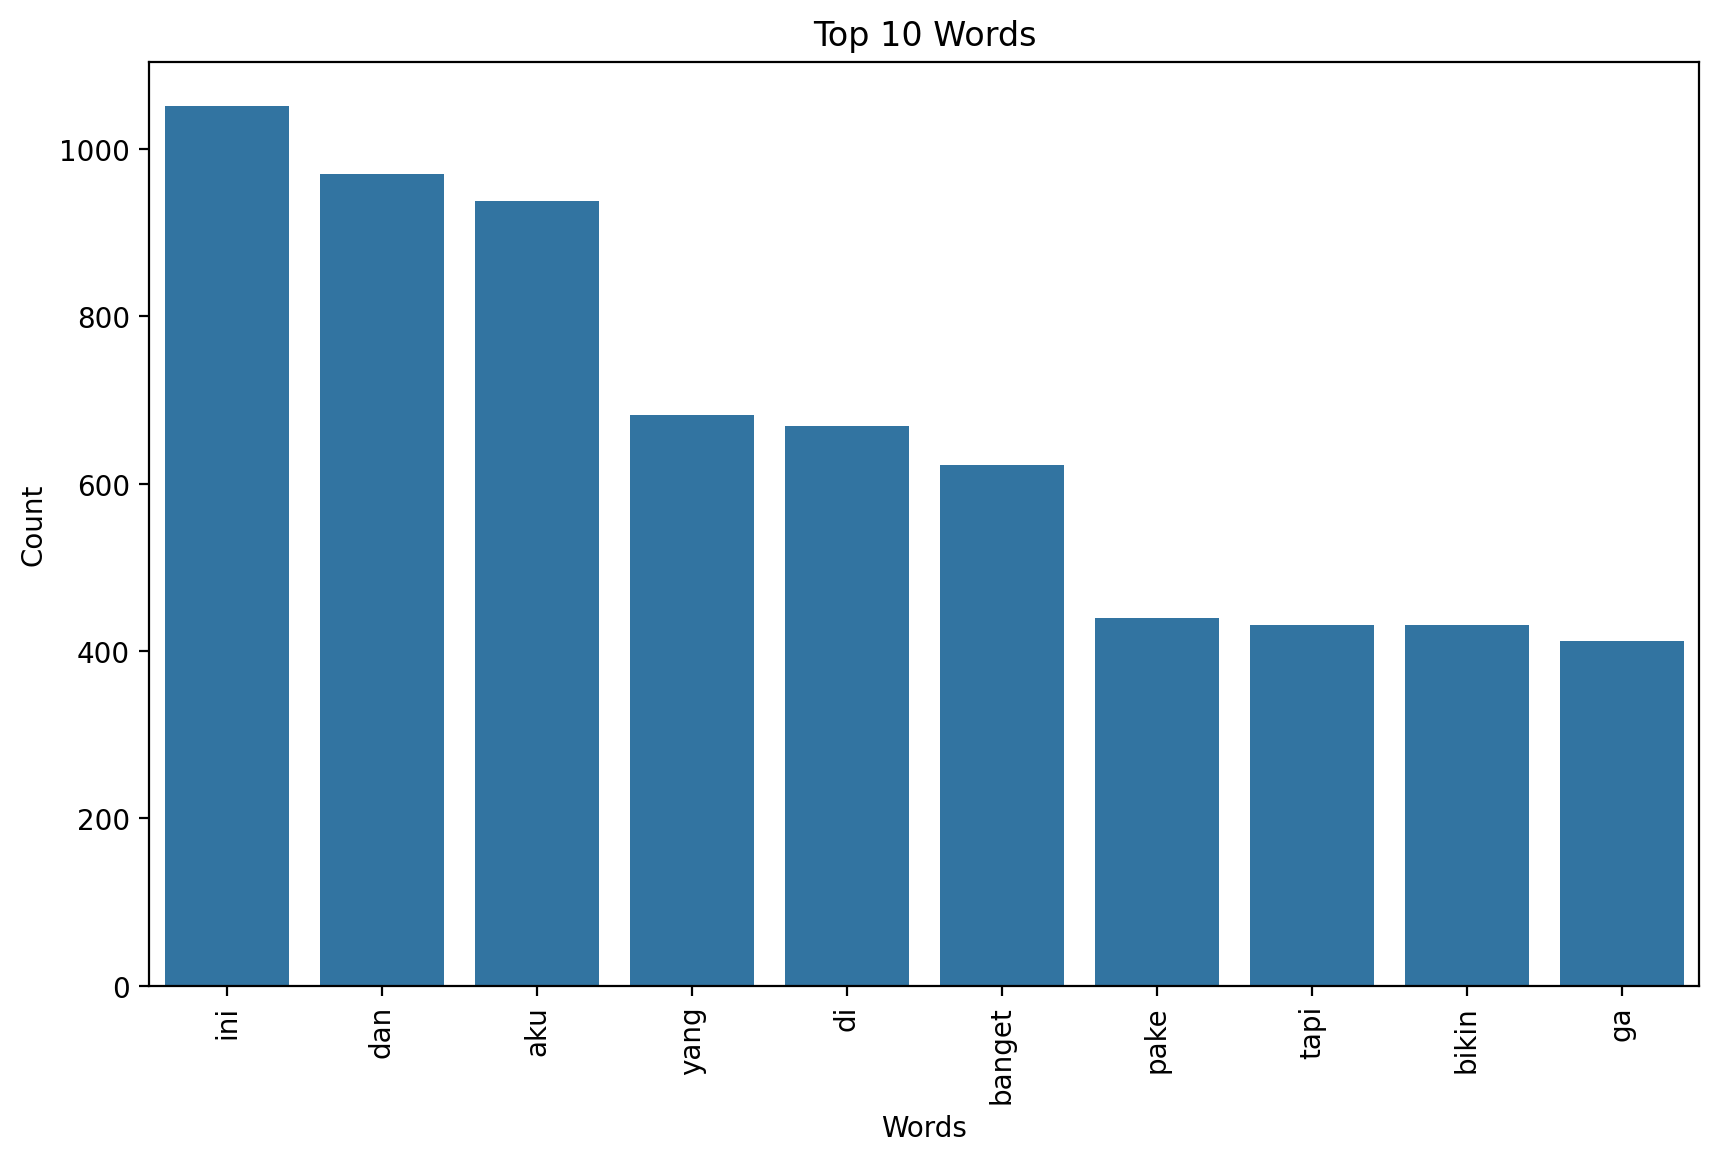

In [129]:
top_10_words = word_count_df_sort.head(10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='key', y='count', data=top_10_words, ax=ax)
plt.title("Top 10 Words")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation='vertical')
plt.show()

# Stopword Removal

In [130]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [131]:
from nltk.corpus import stopwords

In [132]:
list_stopwords = stopwords.words('indonesian')
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       'yah'])

txt_stopword = pd.read_csv("https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/82c73387636132ec7faa30c99ef5e788b3bf62bd/stopwords.txt", names= ["stopwords"], header = None)
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]
df['reviews_tokens_WSW'] = df['reviews_tokens'].apply(stopwords_removal)

# Stemming

In [133]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

In [134]:
df_normalized = pd.DataFrame(df['label'])
df_normalized['reviews'] = df['reviews']

In [135]:
normalizad_word = df_normalized

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

df['reviews_normalized'] = df['reviews_tokens_WSW'].apply(normalized_term)


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['reviews_normalized']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['reviews_tokens_stemmed'] = df['reviews_normalized'].swifter.apply(get_stemmed_term)

2378
------------------------
rame : rame
banget : banget
bahas : bahas
film : film
animasi : animasi
terbaru : baru
studio : studio
kagum : kagum
kualitas : kualitas
animasinya : animasi
ceritanya : cerita
touching : touching
marketplace : marketplace
ngasih : ngasih
promo : promo
gede : gede
gedean : gede
lumayan : lumayan
suka : suka
belanja : belanja
hemat : hemat
temen : temen
gue : gue
ngga : ngga
warna : warna
kebalikan : balik
fleur : fleur
peach : peach
mukanya : muka
girl : girl
kering : kering
dipake : dipake
pake : pake
lip : lip
balm : balm
baunya : bau
aneh : aneh
ilang : ilang
aplikatornya : aplikatornya
harganya : harga
murah : murah
liquid : liquid
lipstick : lipstick
dibawah : bawah
100rb : 100rb
facial : facial
wash : wash
kulit : kulit
satu2nya : satu2nya
penolong : tolong
warnanya : warna
super : super
cantik : cantik
love : love
not : not
into : into
nude : nude
lips : lips
everyday : everyday
prefer : prefer
warna2 : warna2
tua : tua
sehari2 : sehari2
karna : kar

Pandas Apply:   0%|          | 0/1200 [00:00<?, ?it/s]

# Merge

In [136]:
def merge_again(text):
    return ' '.join(text)

In [137]:
df['done_reviews'] = df['reviews_tokens_stemmed'].apply(merge_again)

In [138]:
for i in range(51):
  print(df['done_reviews'].iloc[i])

rame banget bahas film animasi baru studio kagum kualitas animasi cerita touching
marketplace ngasih promo gede gede lumayan banget suka belanja hemat
temen gue ngga suka banget warna balik gue fleur peach muka girl kering dipake ngga pake lip balm bau aneh dipake ilang aplikatornya gue harga murah liquid lipstick bawah 100rb
facial wash kulit
satu2nya tolong girl fleur warna fleur warna super cantik banget love not into nude lips everyday prefer warna2 tua sehari2 karna pake nude lipstick muka pucet kusam different with this one fleur jatohnya bibir peachy light orangey washed out kecewa texturenya sticky sayang bangett warna cantik karna texturenya sticky nyaman dipake hubung fleur cantik banget warna harga murah lumayan koleksi ganti2 lipstick
beli penasaran liquid lipstick hype harga lumayan murah beli suka warna nude pucet jatohnya mlbb cocok daily asa kering suka luntur dalem awet cracking sebenernya beranta susah resin lagi diapus ulang lengket kering kering cepet aplikatornya p

In [139]:
df.head()


,username,rate,date,label,sentimen,reviews,produk,text_length,anomaly_score,reviews_tokens,reviews_tokens_WSW,reviews_normalized,reviews_tokens_stemmed,done_reviews,label_encoded,sentiment_encoded
2244,ilmamli,3,12-08-2015 10:02,non,neutral,rame banget yang bahas soal film animasi terba...,Lip Cream LA Girl,138,1,"[rame, banget, yang, bahas, soal, film, animas...","[rame, banget, bahas, film, animasi, terbaru, ...","[rame, banget, bahas, film, animasi, terbaru, ...","[rame, banget, bahas, film, animasi, baru, stu...",rame banget bahas film animasi baru studio kag...,1,1
2195,ellabcd,3,10-05-2021 11:56,non,neutral,marketplace sekarang banyak yang ngasih promo ...,Acnes Creamy Wash,103,1,"[marketplace, sekarang, banyak, yang, ngasih, ...","[marketplace, ngasih, promo, gede, gedean, lum...","[marketplace, ngasih, promo, gede, gedean, lum...","[marketplace, ngasih, promo, gede, gede, lumay...",marketplace ngasih promo gede gede lumayan ban...,1,1
541,ndinv,3,31-01-2016 8:46,trusted,neutral,temen gue ngga suka banget warna ini kebalikan...,Lip Cream LA Girl,336,1,"[temen, gue, ngga, suka, banget, warna, ini, k...","[temen, gue, ngga, suka, banget, warna, kebali...","[temen, gue, ngga, suka, banget, warna, kebali...","[temen, gue, ngga, suka, banget, warna, balik,...",temen gue ngga suka banget warna balik gue fle...,2,1
2016,SintaRahayu27,3,19-06-2018 11:39,fake,neutral,facial wash ini benar benar biasa saja untuk k...,Produk Skincare,56,1,"[facial, wash, ini, benar, benar, biasa, saja,...","[facial, wash, kulit]","[facial, wash, kulit]","[facial, wash, kulit]",facial wash kulit,0,1
616,syabrinand,3,16-09-2015 4:55,trusted,neutral,satu2nya penolong dari si la girl fleur ini ad...,Lip Cream LA Girl,718,1,"[satu2nya, penolong, dari, si, la, girl, fleur...","[satu2nya, penolong, girl, fleur, warnanya, fl...","[satu2nya, penolong, girl, fleur, warnanya, fl...","[satu2nya, tolong, girl, fleur, warna, fleur, ...",satu2nya tolong girl fleur warna fleur warna s...,2,1


# Modeling

In [140]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, concatenate, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.regularizers import l1, l2
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from keras.optimizers import Adam


In [141]:
# Encode labels
label_encoder_review = LabelEncoder()
label_encoder_sentiment = LabelEncoder()
df['label_encoded'] = label_encoder_review.fit_transform(df['label'])
df['sentiment_encoded'] = label_encoder_sentiment.fit_transform(df['sentimen'])

In [142]:
# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['done_reviews'])
sequences = tokenizer.texts_to_sequences(df['done_reviews'])
word_index = tokenizer.word_index

In [143]:
# Padding sequences
max_sequence_length = 100  # Adjust as needed
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [144]:
# Prepare embedding matrix with Word2Vec
w2v_model = Word2Vec(sentences=[text.split() for text in df['done_reviews']], vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [145]:
# Split the data
X_train, X_test, y_train_label, y_test_label, y_train_sentiment, y_test_sentiment = train_test_split(
    data, df['label_encoded'], df['sentiment_encoded'], test_size=0.2, random_state=42
)

In [146]:
# Define the model
input_ = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_sequence_length, trainable=False)
embedding_layer.build((None,))  # Build the embedding layer
embedding_layer.set_weights([embedding_matrix])  # Set the weights of the embedding layer

embedding = embedding_layer(input_)
embedding = Dropout(0.5)(embedding)

In [147]:
# Convolutional layer
conv = Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01))(embedding)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Dropout(0.5)(conv)


In [148]:
# # LSTM layer
# lstm_out = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(embedding)
# lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after first LSTM
# lstm_out = LSTM(64, kernel_regularizer=l2(0.01))(lstm_out)
# lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after second LSTM

In [149]:
# Bidirectional LSTM layers
lstm_out = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))(conv)
lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after first Bidirectional LSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after second Bidirectional LSTM
lstm_out = LSTM(32, kernel_regularizer=l2(0.01))(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after third LSTM

In [150]:
# Additional Dense and Dropout layers
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(lstm_out)
dense_out = Dropout(0.5)(dense_out)
dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense_out)
dense_out = Dropout(0.5)(dense_out)
dense_out = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense_out)
dense_out = Dropout(0.5)(dense_out)

In [151]:
# Output layers
output_review = Dense(3, activation='softmax', name='review_output', kernel_regularizer=l2(0.01))(dense_out)
output_sentiment = Dense(3, activation='softmax', name='sentiment_output', kernel_regularizer=l2(0.01))(dense_out)


In [152]:
# Combine into a model
model = Model(inputs=input_, outputs=[output_review, output_sentiment])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam',
#               loss={'review_output': 'sparse_categorical_crossentropy', 'sentiment_output': 'sparse_categorical_crossentropy'},
#               metrics={'review_output': 'accuracy', 'sentiment_output': 'accuracy'})


In [153]:
# Summary of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 100)             205000    ['input_2[0][0]']             
                                                                                                  
 dropout_8 (Dropout)         (None, 100, 100)             0         ['embedding_1[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 96, 64)               32064     ['dropout_8[0][0]']           
                                                                                            

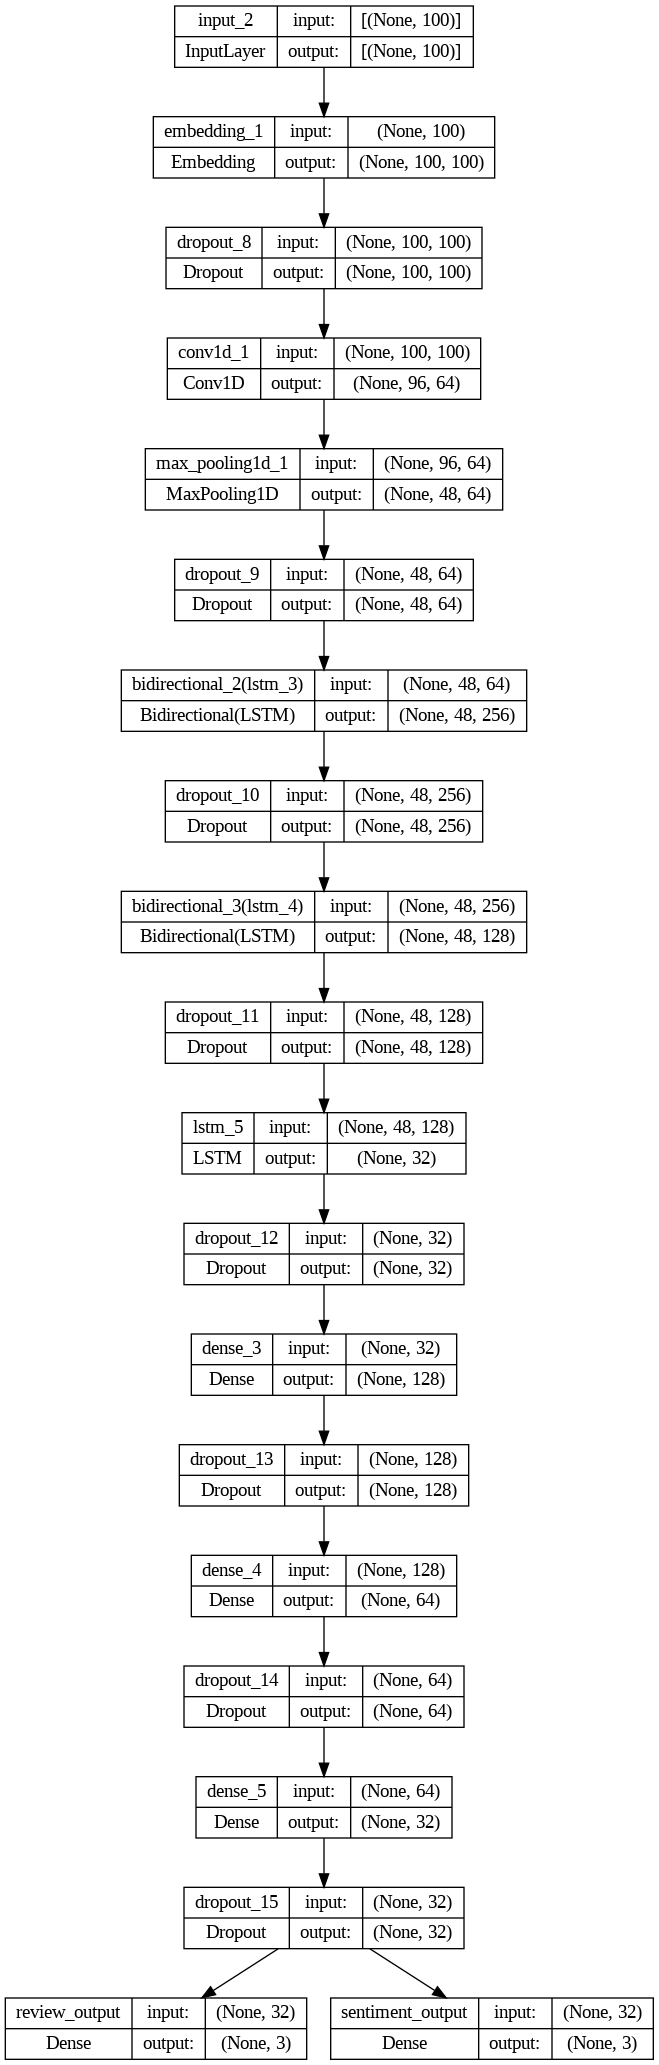

In [154]:
from keras.utils import plot_model

# Visualize the model and save it to file
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [155]:
# Compile the model with metrics for each output
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss={'review_output': 'sparse_categorical_crossentropy', 'sentiment_output': 'sparse_categorical_crossentropy'},
              metrics={'review_output': 'accuracy', 'sentiment_output': 'accuracy'})

In [156]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Early Stopping and Model Checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [169]:
# Train the model with callbacks
history = model.fit(
    X_train,
    {'review_output': y_train_label, 'sentiment_output': y_train_sentiment},
    epochs=100,
    batch_size=20,
    validation_split=0.2,
    # callbacks=[early_stopping, model_checkpoint]
    callbacks=[model_checkpoint]
)

Epoch 1/100
39/39 [==============================] - 11s 282ms/step - loss: 1.9675 - review_output_loss: 0.7863 - sentiment_output_loss: 1.0968 - review_output_accuracy: 0.6432 - sentiment_output_accuracy: 0.3633 - val_loss: 1.9939 - val_review_output_loss: 0.8057 - val_sentiment_output_loss: 1.1004 - val_review_output_accuracy: 0.6250 - val_sentiment_output_accuracy: 0.3542
Epoch 2/100
39/39 [==============================] - 20s 517ms/step - loss: 1.9655 - review_output_loss: 0.7794 - sentiment_output_loss: 1.0992 - review_output_accuracy: 0.6367 - sentiment_output_accuracy: 0.3294 - val_loss: 1.9741 - val_review_output_loss: 0.7873 - val_sentiment_output_loss: 1.1005 - val_review_output_accuracy: 0.6198 - val_sentiment_output_accuracy: 0.3646
Epoch 3/100
39/39 [==============================] - 22s 572ms/step - loss: 1.9329 - review_output_loss: 0.7506 - sentiment_output_loss: 1.0972 - review_output_accuracy: 0.6523 - sentiment_output_accuracy: 0.3646 - val_loss: 1.9747 - val_review

In [170]:
# Evaluate the model
results = model.evaluate(X_test, {'review_output': y_test_label, 'sentiment_output': y_test_sentiment})
print(f'Test results - Loss: {results[0]} - Review Output Loss: {results[1]} - Sentiment Output Loss: {results[2]}')

8/8 [==============================] - 1s 69ms/step - loss: 1.9014 - review_output_loss: 0.7319 - sentiment_output_loss: 1.0967 - review_output_accuracy: 0.6458 - sentiment_output_accuracy: 0.3583
Test results - Loss: 1.9014315605163574 - Review Output Loss: 0.7319406867027283 - Sentiment Output Loss: 1.0967425107955933


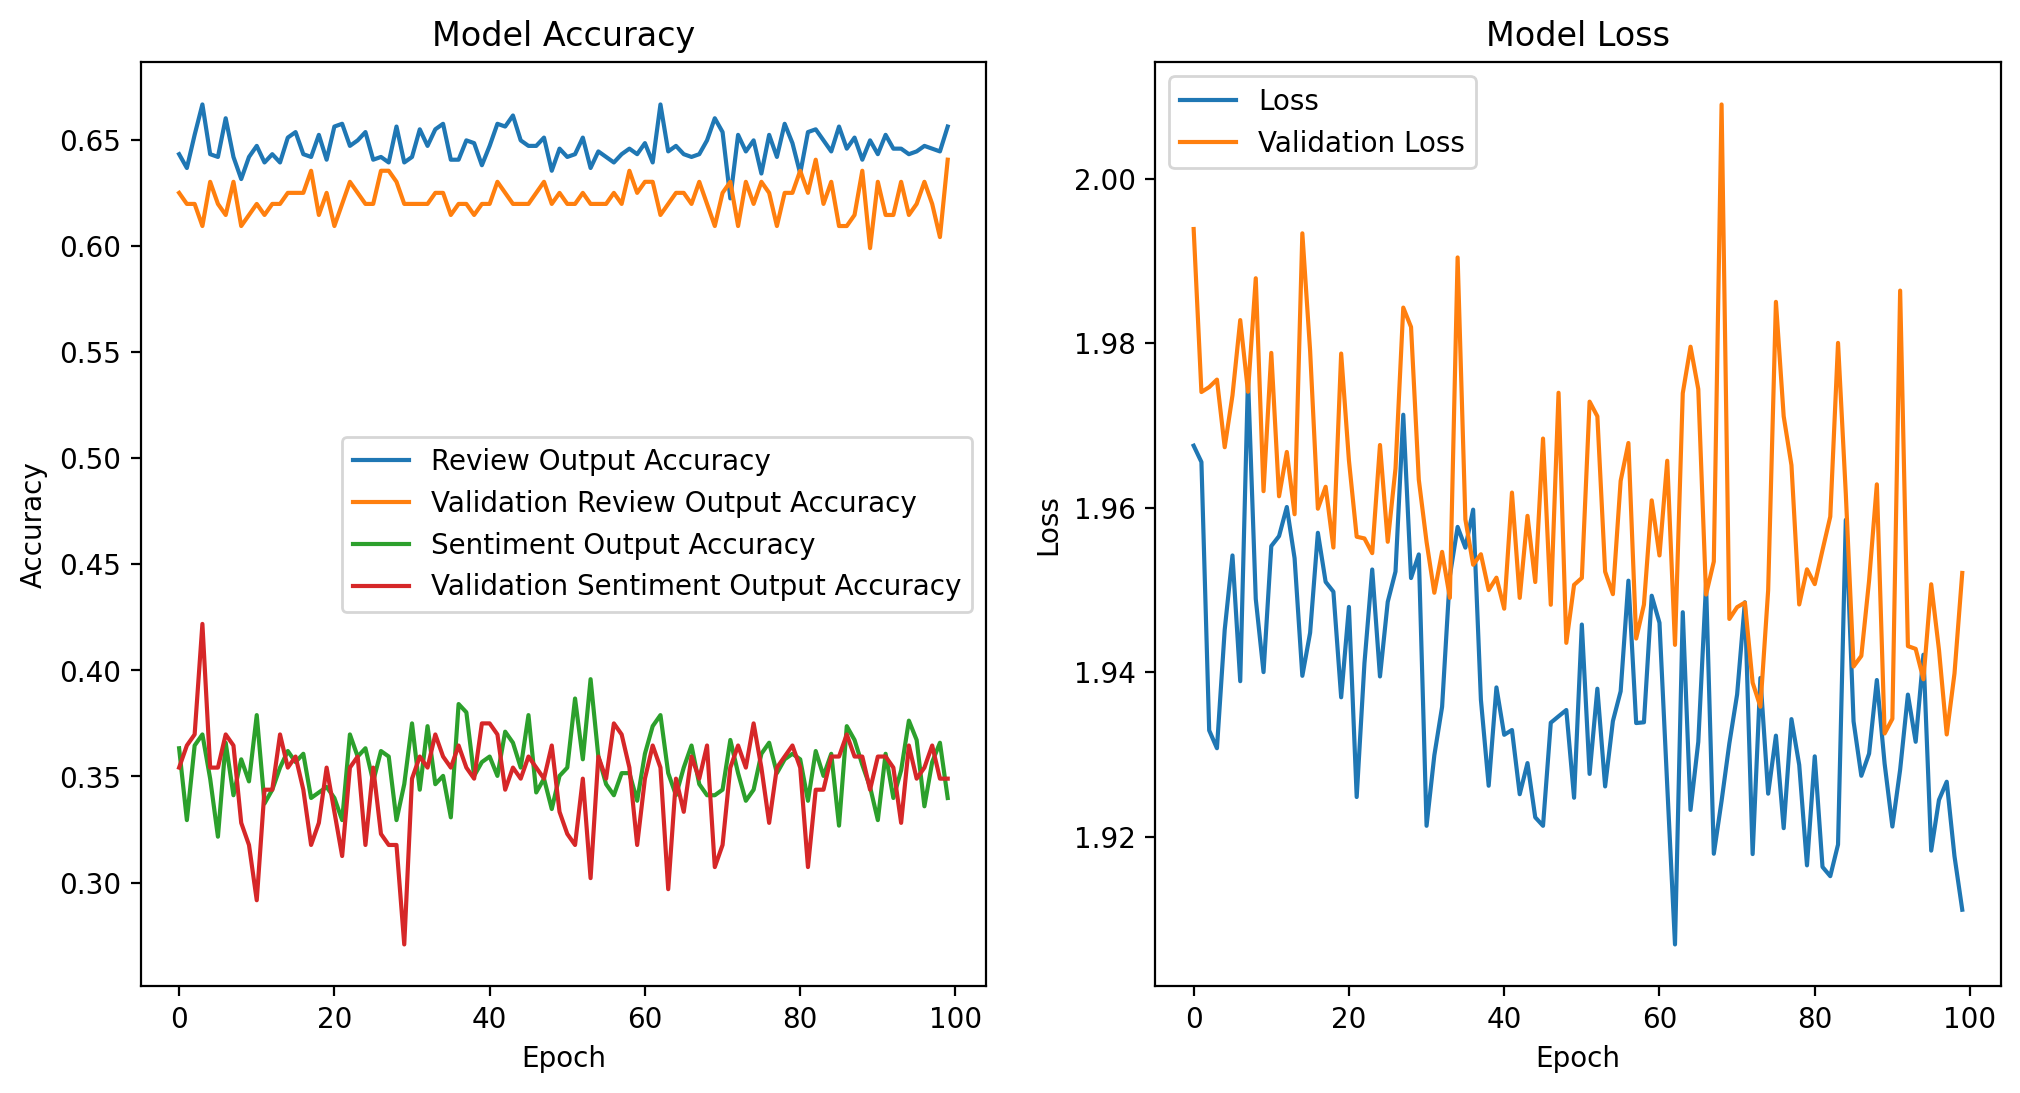

In [171]:
import matplotlib.pyplot as plt

# Plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['review_output_accuracy'], label='Review Output Accuracy')
    plt.plot(history.history['val_review_output_accuracy'], label='Validation Review Output Accuracy')
    plt.plot(history.history['sentiment_output_accuracy'], label='Sentiment Output Accuracy')
    plt.plot(history.history['val_sentiment_output_accuracy'], label='Validation Sentiment Output Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot learning curve
plot_learning_curve(history)


In [160]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Predict on the test set
y_test_pred_review = np.argmax(model.predict(X_test)[0], axis=1)
y_test_pred_sentiment = np.argmax(model.predict(X_test)[1], axis=1)

# Convert labels back to original encoding
y_test_true_review = y_test_label
y_test_true_sentiment = y_test_sentiment

8/8 [==============================] - 1s 65ms/step


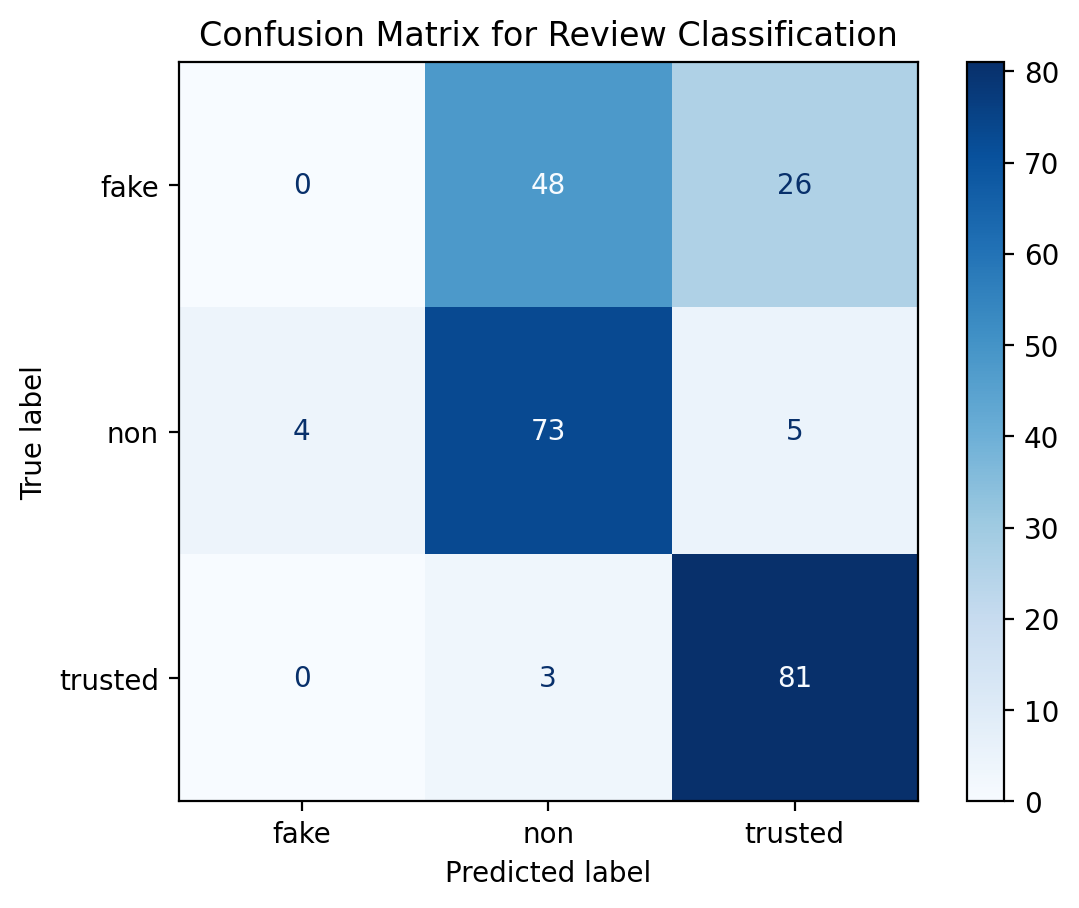

In [161]:
# Plot confusion matrix for review prediction
cm_review = confusion_matrix(y_test_true_review, y_test_pred_review)
disp_review = ConfusionMatrixDisplay(confusion_matrix=cm_review, display_labels=label_encoder_review.classes_)
disp_review.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Review Classification')
plt.show()

In [162]:
print(classification_report(y_test_true_review, y_test_pred_review, digits = 4))

print("Accuracy score: ", accuracy_score(y_test_true_review, y_test_pred_review) * 100, '%')

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        74
           1     0.5887    0.8902    0.7087        82
           2     0.7232    0.9643    0.8265        84

    accuracy                         0.6417       240
   macro avg     0.4373    0.6182    0.5118       240
weighted avg     0.4543    0.6417    0.5314       240

Accuracy score:  64.16666666666667 %


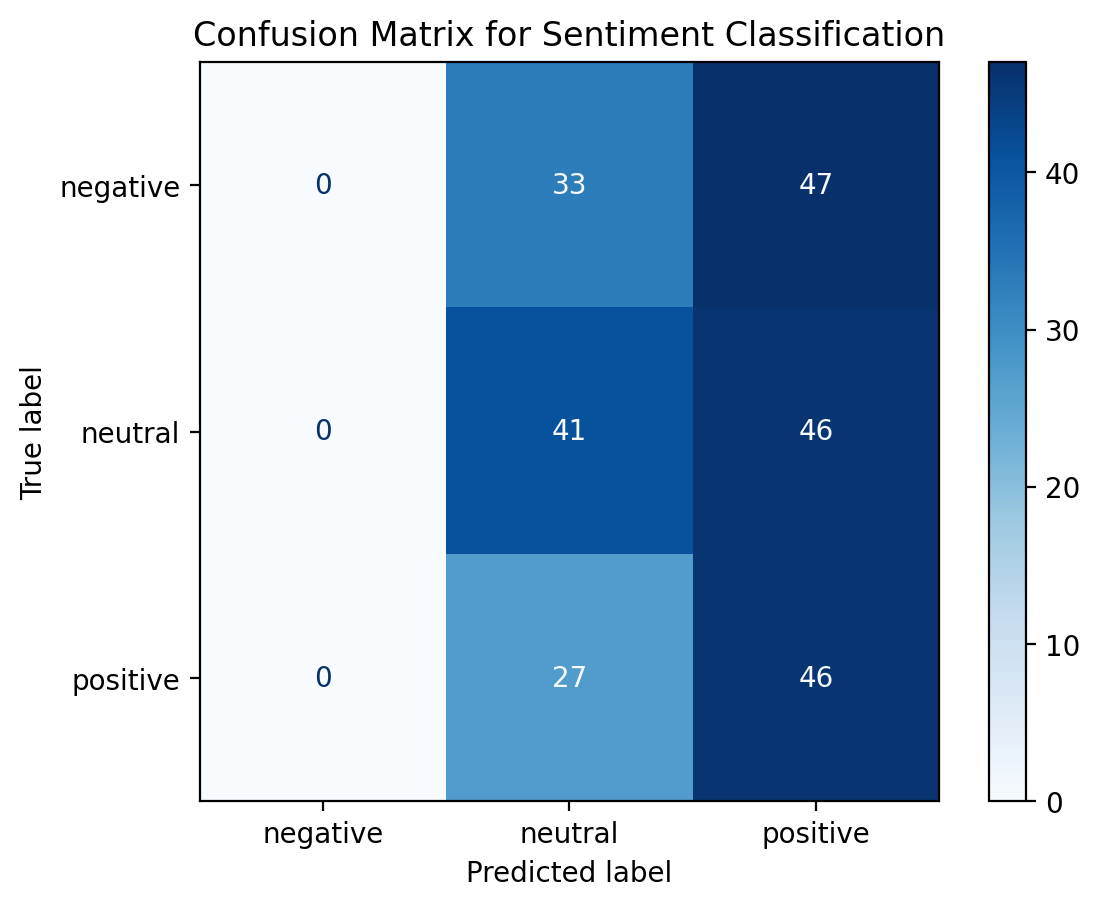

In [163]:
# Plot confusion matrix for sentiment prediction
cm_sentiment = confusion_matrix(y_test_true_sentiment, y_test_pred_sentiment)
disp_sentiment = ConfusionMatrixDisplay(confusion_matrix=cm_sentiment, display_labels=label_encoder_sentiment.classes_)
disp_sentiment.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Sentiment Classification')
plt.show()

In [164]:
print(classification_report(y_test_true_sentiment, y_test_pred_sentiment, digits = 4))

print("Accuracy score: ", accuracy_score(y_test_true_sentiment, y_test_pred_sentiment) * 100, '%')

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        80
           1     0.4059    0.4713    0.4362        87
           2     0.3309    0.6301    0.4340        73

    accuracy                         0.3625       240
   macro avg     0.2456    0.3671    0.2900       240
weighted avg     0.2478    0.3625    0.2901       240

Accuracy score:  36.25 %


In [165]:
# Function for prediction with percentage
def predict_review_with_percentage(model, tokenizer, review_text):
    sequence = tokenizer.texts_to_sequences([review_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequence)

    review_pred = label_encoder_review.inverse_transform(np.argmax(prediction[0], axis=1))[0]
    sentiment_pred = label_encoder_sentiment.inverse_transform(np.argmax(prediction[1], axis=1))[0]

    # Calculate percentage
    review_percentage = np.max(prediction[0]) * 100
    sentiment_percentage = np.max(prediction[1]) * 100

    return review_pred, review_percentage, sentiment_pred, sentiment_percentage



# Function to predict star rating based on sentiment percentage
def predict_star_rating(sentiment_percentage):
    if sentiment_percentage <= 20:
        return 1
    elif sentiment_percentage <= 40:
        return 2
    elif sentiment_percentage <= 60:
        return 3
    elif sentiment_percentage <= 80:
        return 4
    else:
        return 5




In [166]:
# Example usage by user input
user_review = input("Masukkan review produk: ")
review_pred, review_percentage, sentiment_pred, sentiment_percentage = predict_review_with_percentage(model, tokenizer, user_review)

# Predict star rating based on sentiment percentage
star_rating = predict_star_rating(sentiment_percentage)
print(' ________________  Review Analysis Result ______________')
print(f'| Review : {review_pred} - Percentage: {review_percentage:.2f}%','                    |')
print(f'| Sentiment : {sentiment_pred} - Percentage: {sentiment_percentage:.2f}%','            |')
print(f'| Star Rating: {star_rating}','                                       |')
print(' -------------------------------------------------------')

Masukkan review produk: sip
1/1 [==============================] - 0s 68ms/step
 ________________  Review Analysis Result ______________
| Review : non - Percentage: 58.19%                     |
| Sentiment : positive - Percentage: 33.62%             |
| Star Rating: 2                                        |
 -------------------------------------------------------
